## Analysis v5: Detecting Covariant Sites 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from natsort import index_natsorted

In [2]:
# Set color values
dutchfield = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

springpastel = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

### Calculating the Variance of the AF and FPS values 

It would be quite interesting to see if for each variant site per motif, the variance of the AF and FPS values are correlated.

I.e. if a variant site has a high variance in AF values, does it also have a high variance in FPS values?

First, load the data file as dataframe and then truncate the columns to include on AF and FPS data. Next, convert the dataframe into long format.

In [3]:
# import the data
# filepath = '/home/users/ntu/suffiazi/scratch/outputs/tmp/input_data/E2F5_E2F5_HUMAN.H11MO.0.B_fpscore-af-varsites-combined-matrix-wide.tsv'
filepath = '../raw-data/combined_matrix/PATZ1_PATZ1_HUMAN.H11MO.0.C_fpscore-af-varsites-combined-matrix-wide.tsv'
dt_afps = pd.read_csv(filepath, sep='\t')
# extract motif id from filename
motif_id = os.path.basename(filepath).replace('_fpscore-af-varsites-combined-matrix-wide.tsv', '')
motif_id

'PATZ1_PATZ1_HUMAN.H11MO.0.C'

In [4]:
dt_afps.head()

Chromosome   Start     End  98JKPD8_lumA_fps  ANAB5F7_basal_fps  \
0       chr1   29434   29456               0.0                0.0   
1       chr1  136931  136953               0.0                0.0   
2       chr1  181521  181543               0.0                0.0   
3       chr1  181572  181594               0.0                0.0   
4       chr1  182780  182802               0.0                0.0   

   S6R691V_her2_fps  PU24GB8_lumB_fps  2GAMBDQ_norm_fps  \
0               0.0               0.0               0.0   
1               0.0               0.0               0.0   
2               0.0               0.0               0.0   
3               0.0               0.0               0.0   
4               0.0               0.0               0.0   

   2GAMBDQ_norm_varsite_pos 2GAMBDQ_norm_ref_allele  ... ANAB5F7_basal_AF  \
0                       NaN                     NaN  ...         0.807692   
1                  136940.0                       G  ...         0.058824   
2                       NaN                     NaN  ...         0.088235   
3                       NaN                     NaN  ...         0.000000   
4                       NaN                     NaN  ...         0.000000   

   PU24GB8_lumB_varsite_pos  PU24GB8_lumB_ref_allele PU24GB8_lumB_alt_allele  \
0                   29443.0                        A                       G   
1                  136939.0                        G                       T   
2                  181526.0                        C                       T   
3                  181573.0                        G                       A   
4                  182785.0                        A                       G   

  PU24GB8_lumB_AF  S6R691V_her2_varsite_pos  S6R691V_her2_ref_allele  \
0        1.000000                   29443.0                        A   
1        0.052632                       NaN                      NaN   
2        0.052632                  181526.0                        C   
3        0.026316                  181583.0       CGGGGGGGGGGGGGGGGG   
4        0.083333                       NaN                      NaN   

  S6R691V_her2_alt_allele S6R691V_her2_AF           region_id  
0                       G        1.000000    chr1:29434-29456  
1                     NaN        0.000000  chr1:136931-136953  
2                       T        0.117647  chr1:181521-181543  
3          CGGGGGGGGGGGGG        0.117647  chr1:181572-181594  
4                     NaN        0.000000  chr1:182780-182802  

[5 rows x 29 columns]

Let's filter the loaded table to include only the `_AF` and `_fps` columns, as well as the `region_id` column.

In [5]:
afps_df = dt_afps.filter(regex='_AF$|_fps$|_id$').copy()
afps_df.head(5)

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  PU24GB8_lumB_fps  \
0               0.0                0.0               0.0               0.0   
1               0.0                0.0               0.0               0.0   
2               0.0                0.0               0.0               0.0   
3               0.0                0.0               0.0               0.0   
4               0.0                0.0               0.0               0.0   

   2GAMBDQ_norm_fps  2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  \
0               0.0            0.000         1.000000          0.807692   
1               0.0            0.125         0.000000          0.058824   
2               0.0            0.000         0.125000          0.088235   
3               0.0            0.000         0.000000          0.000000   
4               0.0            0.000         0.222222          0.000000   

   PU24GB8_lumB_AF  S6R691V_her2_AF           region_id  
0         1.000000         1.000000    chr1:29434-29456  
1         0.052632         0.000000  chr1:136931-136953  
2         0.052632         0.117647  chr1:181521-181543  
3         0.026316         0.117647  chr1:181572-181594  
4         0.083333         0.000000  chr1:182780-182802

In [6]:
# convert to long format
afps_df_long = afps_df.melt(id_vars=["region_id"], var_name="variable", value_name="value")

# split the variable column into sample_id and type columns using reverse split string method, which returns a dataframe of columns based on the number of splits (n=x); this can directly be assigned to new columns in the original dataframe
afps_df_long[['sample_id', 'type']] = afps_df_long['variable'].str.rsplit('_', n=1, expand=True)

# drop the redundant 'variable' column
afps_df_long = afps_df_long.drop(columns=["variable"])

# now pivot the dataframe to create new columns based on the type column
afps_df_lpv = afps_df_long.pivot(index=['region_id', 'sample_id'], columns='type', values='value').reset_index()

# remove the index name and rename the columns to match the type values
afps_df_lpv = afps_df_lpv.rename_axis(None, axis=1).rename(columns={'fps': 'FPS'})

# sort the dataframe by region_id naturally
afps_df_lpv = afps_df_lpv.reindex(index=index_natsorted(afps_df_lpv['region_id']))
afps_df_lpv = afps_df_lpv.reset_index(drop=True)
afps_df_lpv

region_id      sample_id        AF  FPS
0             chr1:29434-29456   2GAMBDQ_norm  0.000000  0.0
1             chr1:29434-29456   98JKPD8_lumA  1.000000  0.0
2             chr1:29434-29456  ANAB5F7_basal  0.807692  0.0
3             chr1:29434-29456   PU24GB8_lumB  1.000000  0.0
4             chr1:29434-29456   S6R691V_her2  1.000000  0.0
...                        ...            ...       ...  ...
573100  chrY:26671746-26671768   2GAMBDQ_norm  0.000000  0.0
573101  chrY:26671746-26671768   98JKPD8_lumA  0.000000  0.0
573102  chrY:26671746-26671768  ANAB5F7_basal  0.000000  0.0
573103  chrY:26671746-26671768   PU24GB8_lumB  0.500000  0.0
573104  chrY:26671746-26671768   S6R691V_her2  0.000000  0.0

[573105 rows x 4 columns]

### AF–FPS Matrix
At this point, we now have both a matrix of AF and FPS values in wide form (`afps_df`) and the same dataset in long form (`afps_df_lpv`). We can scale the FPS values to be between 0 and 1 now.

In [7]:
# use MinMaxScaler to scale the raw fps values to range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
# scale the FPS values to a range of 0-1
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# copy df
fps_df_scaled = dt_afps.filter(regex='_fps$|_id$').copy()

# set the index to 'region_id'
fps_df_scaled = fps_df_scaled.set_index('region_id')

# Fit the MinMaxScaler to the 'FPS' column and transform it
fps_df_scaled = pd.DataFrame(scaler.fit_transform(fps_df_scaled), columns=fps_df_scaled.columns, index=fps_df_scaled.index)

# rename columns by adding '_scaled' to the column names
fps_df_scaled = fps_df_scaled.add_suffix('_scaled')
fps_df_scaled

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                   
chr1:29434-29456                            0.0                       0.0   
chr1:136931-136953                          0.0                       0.0   
chr1:181521-181543                          0.0                       0.0   
chr1:181572-181594                          0.0                       0.0   
chr1:182780-182802                          0.0                       0.0   
...                                         ...                       ...   
chrY:26671025-26671047                      0.0                       0.0   
chrY:26671055-26671077                      0.0                       0.0   
chrY:26671150-26671172                      0.0                       0.0   
chrY:26671670-26671692                      0.0                       0.0   
chrY:26671746-26671768                      0.0                       0.0   

                        S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                  
chr1:29434-29456                            0.0                      0.0   
chr1:136931-136953                          0.0                      0.0   
chr1:181521-181543                          0.0                      0.0   
chr1:181572-181594                          0.0                      0.0   
chr1:182780-182802                          0.0                      0.0   
...                                         ...                      ...   
chrY:26671025-26671047                      0.0                      0.0   
chrY:26671055-26671077                      0.0                      0.0   
chrY:26671150-26671172                      0.0                      0.0   
chrY:26671670-26671692                      0.0                      0.0   
chrY:26671746-26671768                      0.0                      0.0   

                        2GAMBDQ_norm_fps_scaled  
region_id                                        
chr1:29434-29456                            0.0  
chr1:136931-136953                          0.0  
chr1:181521-181543                          0.0  
chr1:181572-181594                          0.0  
chr1:182780-182802                          0.0  
...                                         ...  
chrY:26671025-26671047                      0.0  
chrY:26671055-26671077                      0.0  
chrY:26671150-26671172                      0.0  
chrY:26671670-26671692                      0.0  
chrY:26671746-26671768                      0.0  

[114621 rows x 5 columns]

Now we should convert the FPS scaled dataframe into long form.

In [8]:
# reset index
fps_df_scaled_long = fps_df_scaled.reset_index()
# convert to long format
fps_df_scaled_long = fps_df_scaled_long.melt(id_vars=["region_id"], var_name="variable", value_name="value")

# split the variable column into sample_id and type columns using reverse split string method, which returns a dataframe of columns based on the number of splits (n=x); this can directly be assigned to new columns in the original dataframe
# Split the 'variable' column into three parts
fps_df_scaled_long[['part1', 'part2', 'part3']] = fps_df_scaled_long['variable'].str.rsplit('_', n=2, expand=True)

# Assign part1 to 'sample_id' and concatenate the other parts to form 'type'
fps_df_scaled_long['sample_id'] = fps_df_scaled_long['part1']
fps_df_scaled_long['type'] = fps_df_scaled_long['part2'].str.upper() + '_' + fps_df_scaled_long['part3']

# Drop the unnecessary columns
fps_df_scaled_long = fps_df_scaled_long.drop(['variable', 'part1', 'part2', 'part3'], axis=1)

# now pivot the dataframe to create new columns based on the type column
fps_df_scaled_lpv = fps_df_scaled_long.pivot(index=['region_id', 'sample_id'], columns='type', values='value').reset_index()

# remove the index name and rename the columns to match the type values
fps_df_scaled_lpv = fps_df_scaled_lpv.rename_axis(None, axis=1)

# sort the dataframe by region_id naturally
fps_df_scaled_lpv = fps_df_scaled_lpv.reindex(index=index_natsorted(fps_df_scaled_lpv['region_id']))
fps_df_scaled_lpv = fps_df_scaled_lpv.reset_index(drop=True)
fps_df_scaled_lpv

region_id      sample_id  FPS_scaled
0             chr1:29434-29456   2GAMBDQ_norm         0.0
1             chr1:29434-29456   98JKPD8_lumA         0.0
2             chr1:29434-29456  ANAB5F7_basal         0.0
3             chr1:29434-29456   PU24GB8_lumB         0.0
4             chr1:29434-29456   S6R691V_her2         0.0
...                        ...            ...         ...
573100  chrY:26671746-26671768   2GAMBDQ_norm         0.0
573101  chrY:26671746-26671768   98JKPD8_lumA         0.0
573102  chrY:26671746-26671768  ANAB5F7_basal         0.0
573103  chrY:26671746-26671768   PU24GB8_lumB         0.0
573104  chrY:26671746-26671768   S6R691V_her2         0.0

[573105 rows x 3 columns]

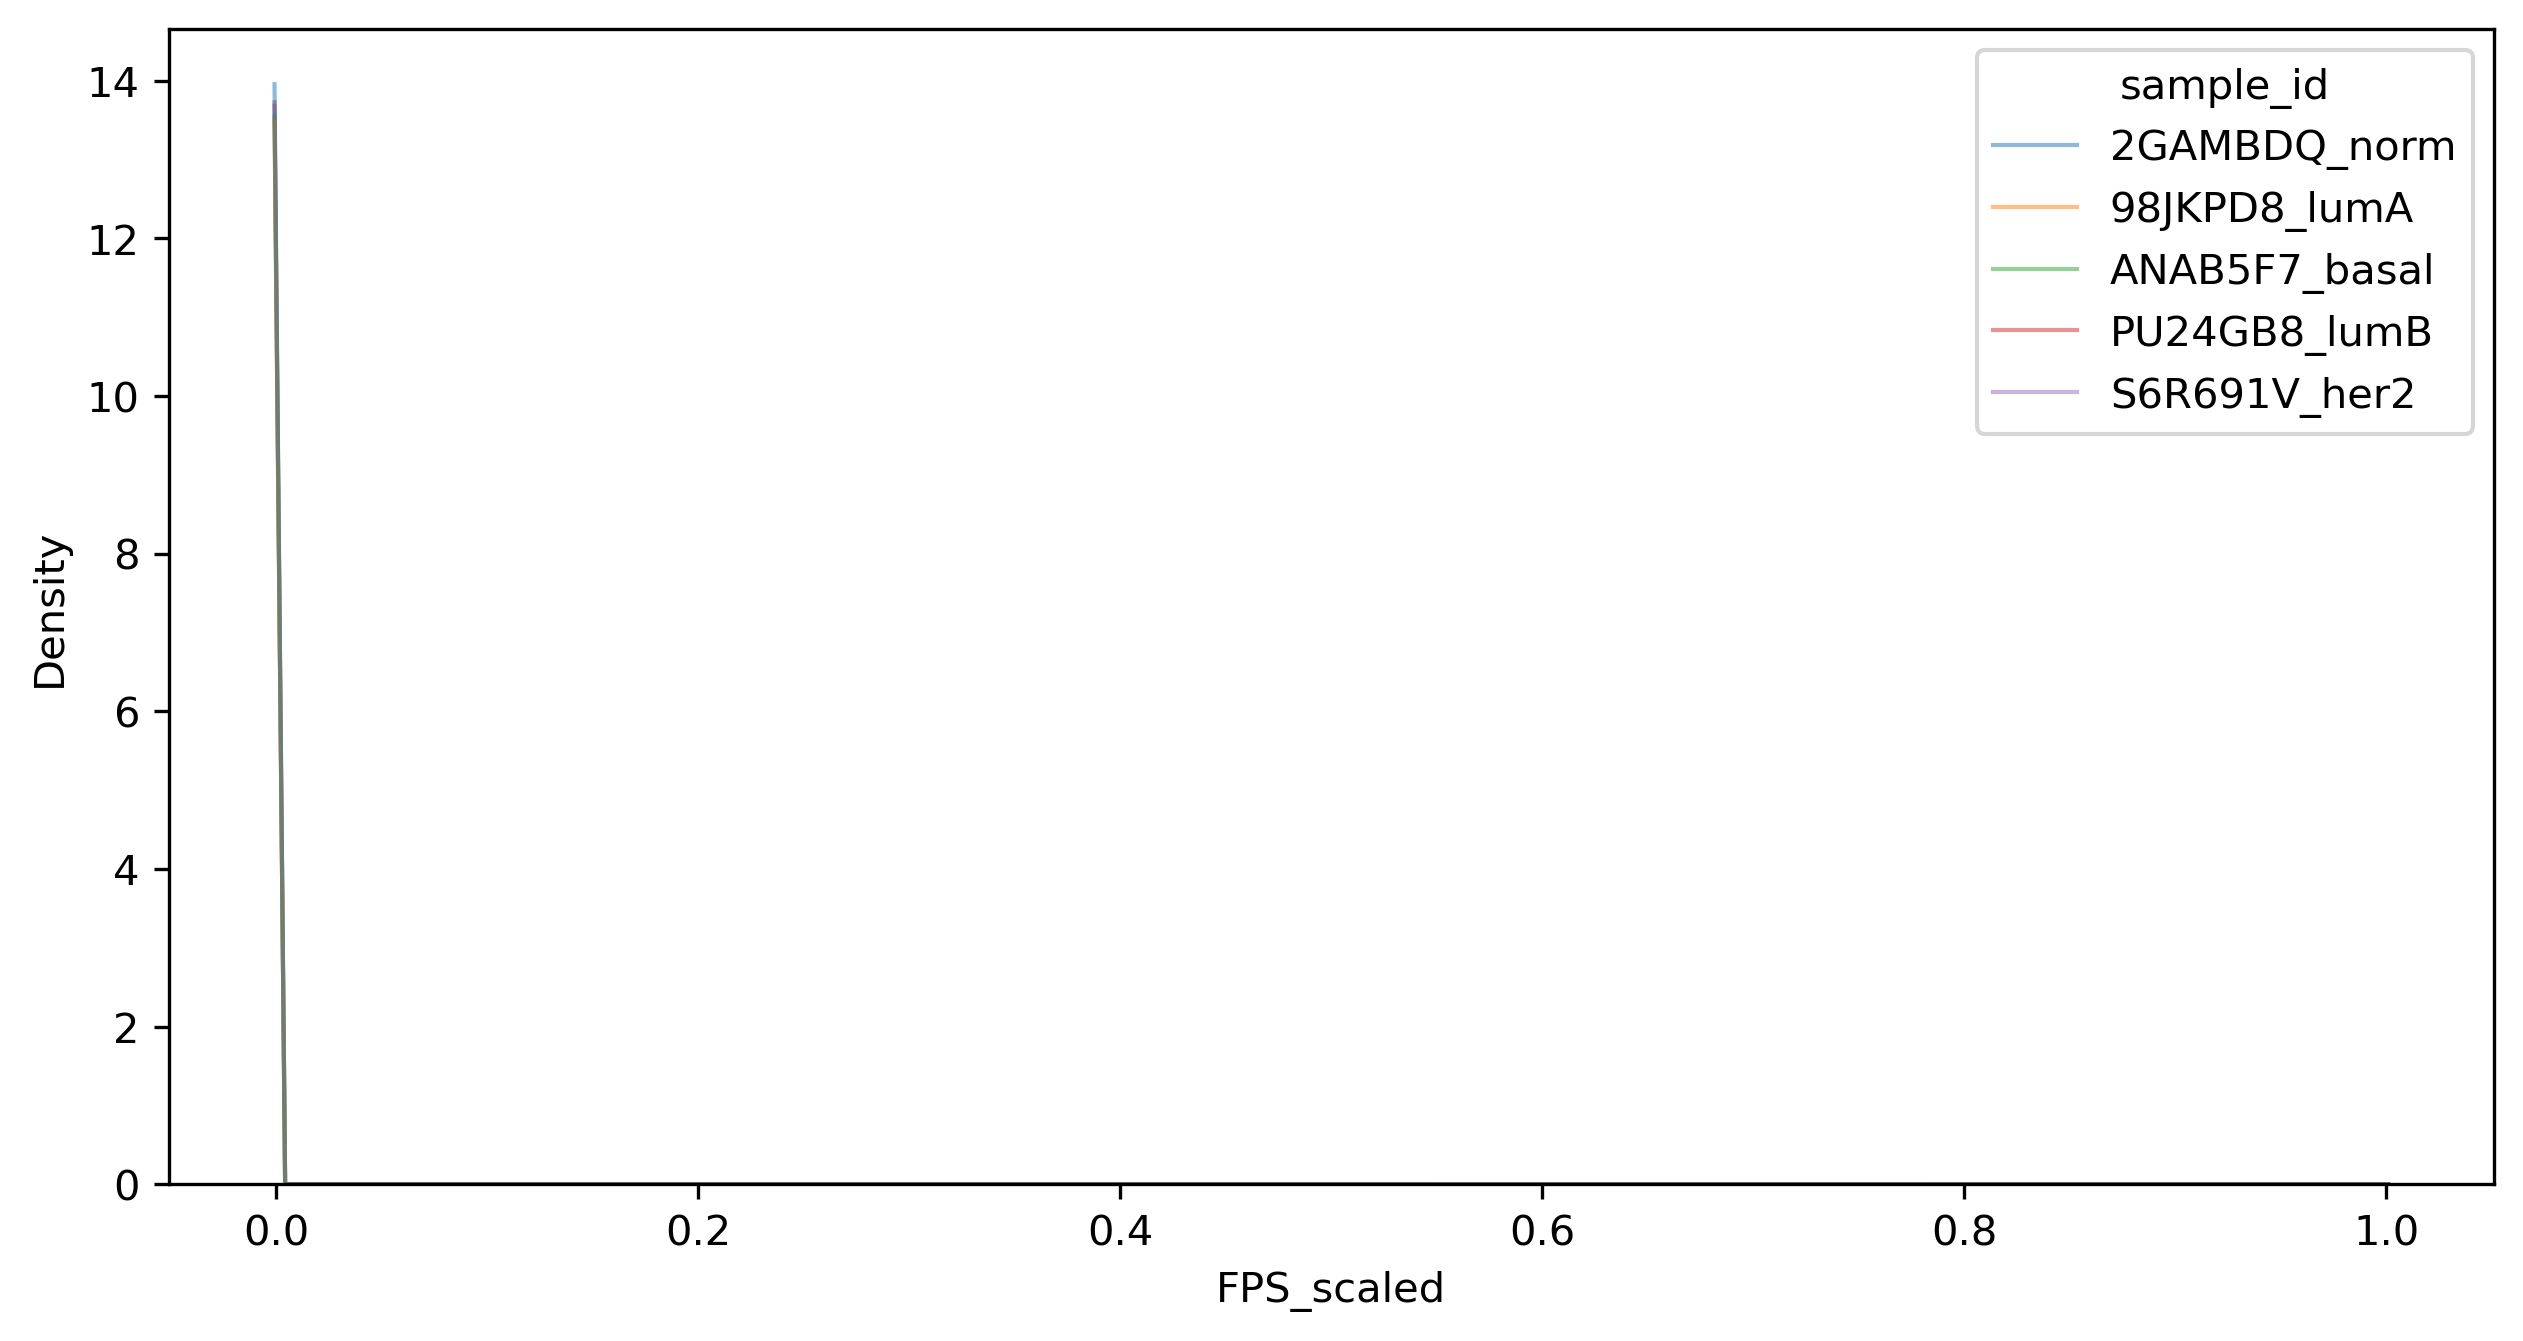

In [9]:
# plot fps distribution
plt.figure(figsize=(10, 5), dpi=300)
sns.kdeplot(data=fps_df_scaled_lpv, x="FPS_scaled", hue="sample_id", fill=False, common_norm=False, alpha=.5, linewidth=1)
plt.show()

### Merging `afps_df_lpv` and `fps_df_scaled_lpv`

Now we can merge the two long dataframes together to get both raw FPS and scaled FPS values in one dataframe.

In [10]:
afps_df_lpv

region_id      sample_id        AF  FPS
0             chr1:29434-29456   2GAMBDQ_norm  0.000000  0.0
1             chr1:29434-29456   98JKPD8_lumA  1.000000  0.0
2             chr1:29434-29456  ANAB5F7_basal  0.807692  0.0
3             chr1:29434-29456   PU24GB8_lumB  1.000000  0.0
4             chr1:29434-29456   S6R691V_her2  1.000000  0.0
...                        ...            ...       ...  ...
573100  chrY:26671746-26671768   2GAMBDQ_norm  0.000000  0.0
573101  chrY:26671746-26671768   98JKPD8_lumA  0.000000  0.0
573102  chrY:26671746-26671768  ANAB5F7_basal  0.000000  0.0
573103  chrY:26671746-26671768   PU24GB8_lumB  0.500000  0.0
573104  chrY:26671746-26671768   S6R691V_her2  0.000000  0.0

[573105 rows x 4 columns]

In [11]:
# merge two dataframes on region_id and sample_id
afps_full_dfl = afps_df_lpv.merge(fps_df_scaled_lpv, on=['region_id', 'sample_id'])
afps_full_dfl

region_id      sample_id        AF  FPS  FPS_scaled
0             chr1:29434-29456   2GAMBDQ_norm  0.000000  0.0         0.0
1             chr1:29434-29456   98JKPD8_lumA  1.000000  0.0         0.0
2             chr1:29434-29456  ANAB5F7_basal  0.807692  0.0         0.0
3             chr1:29434-29456   PU24GB8_lumB  1.000000  0.0         0.0
4             chr1:29434-29456   S6R691V_her2  1.000000  0.0         0.0
...                        ...            ...       ...  ...         ...
573100  chrY:26671746-26671768   2GAMBDQ_norm  0.000000  0.0         0.0
573101  chrY:26671746-26671768   98JKPD8_lumA  0.000000  0.0         0.0
573102  chrY:26671746-26671768  ANAB5F7_basal  0.000000  0.0         0.0
573103  chrY:26671746-26671768   PU24GB8_lumB  0.500000  0.0         0.0
573104  chrY:26671746-26671768   S6R691V_her2  0.000000  0.0         0.0

[573105 rows x 5 columns]

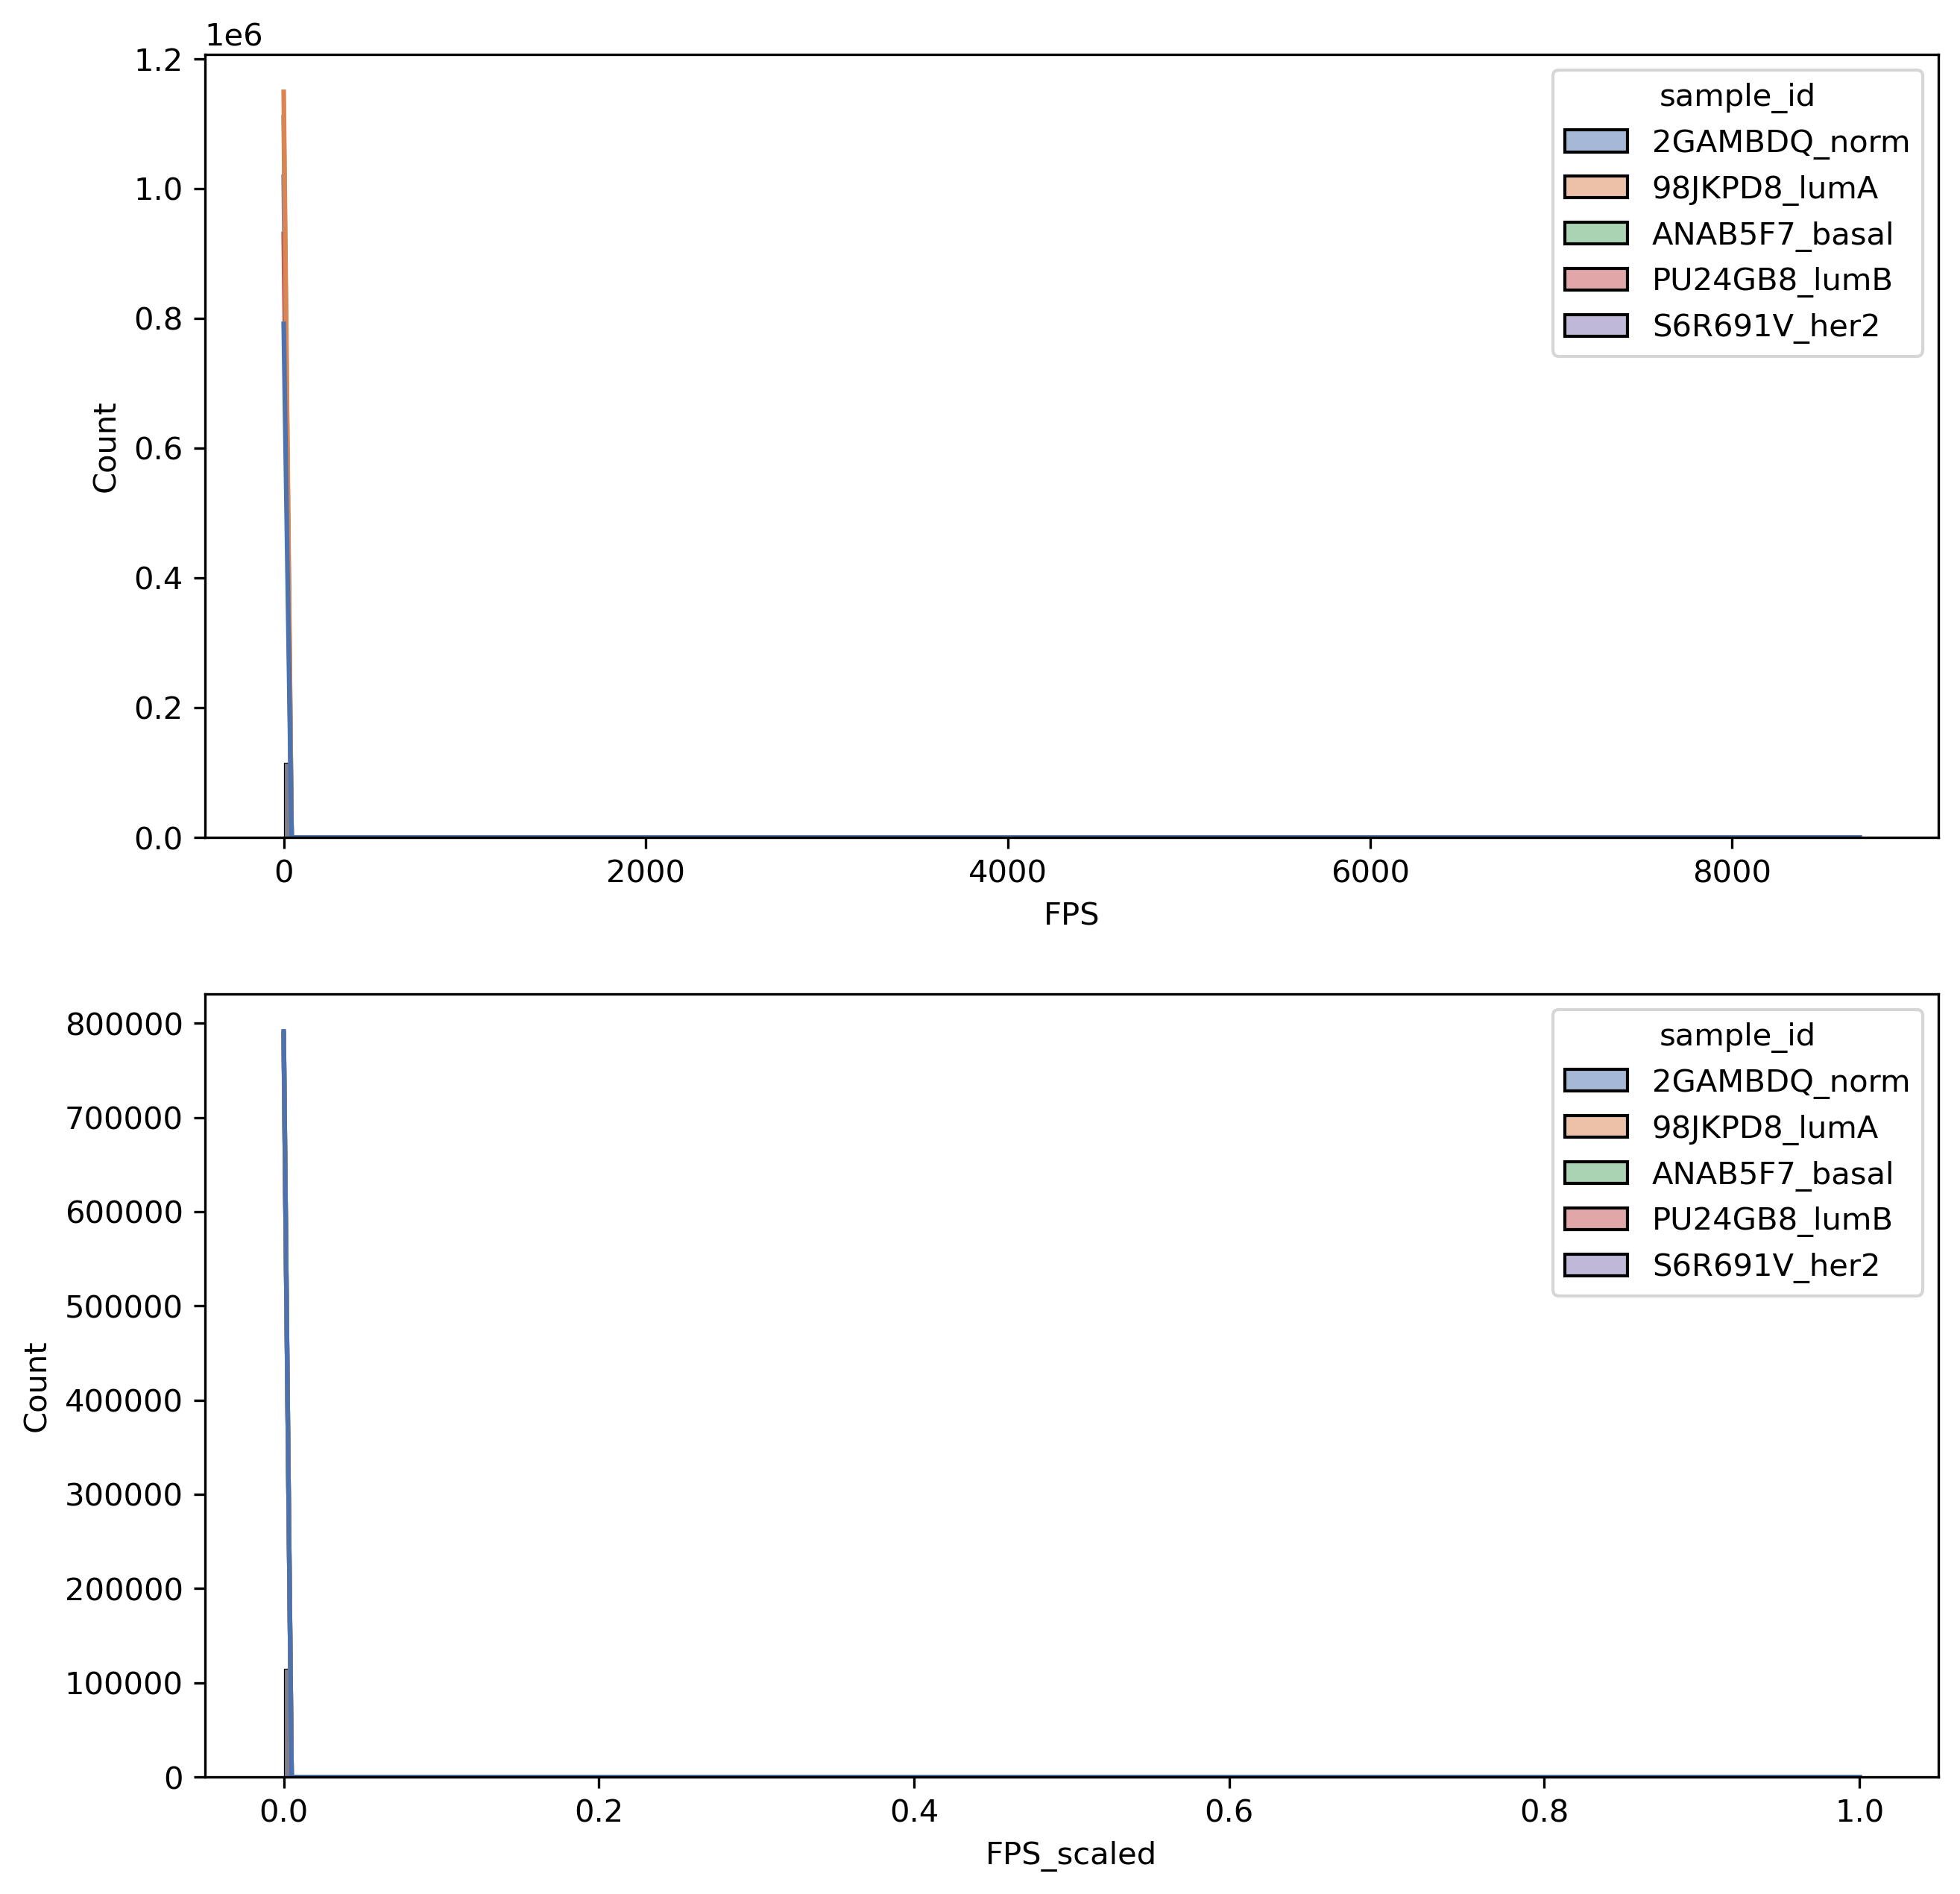

In [12]:
# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=300)
sns.histplot(data=afps_full_dfl, x="FPS", hue="sample_id", bins=200, kde=True, palette="deep", ax=axs[0])
sns.histplot(data=afps_full_dfl, x="FPS_scaled", hue="sample_id", bins=200, kde=True, palette="deep", ax=axs[1])
# # now draw a subset plot where x is above a certain threshold
# sns.histplot(data=afps_full_dfl[afps_full_dfl['FPS'] > 0.5], x="FPS", hue="sample_id", bins=200, kde=True, palette="deep", ax=axs[2])
# plt.title(f"FPS distribution of {motif_id} in all samples")
plt.show()

Text(0.5, 0.98, 'Jointpot of AF and scaled FPS values of PATZ1_PATZ1_HUMAN.H11MO.0.C')

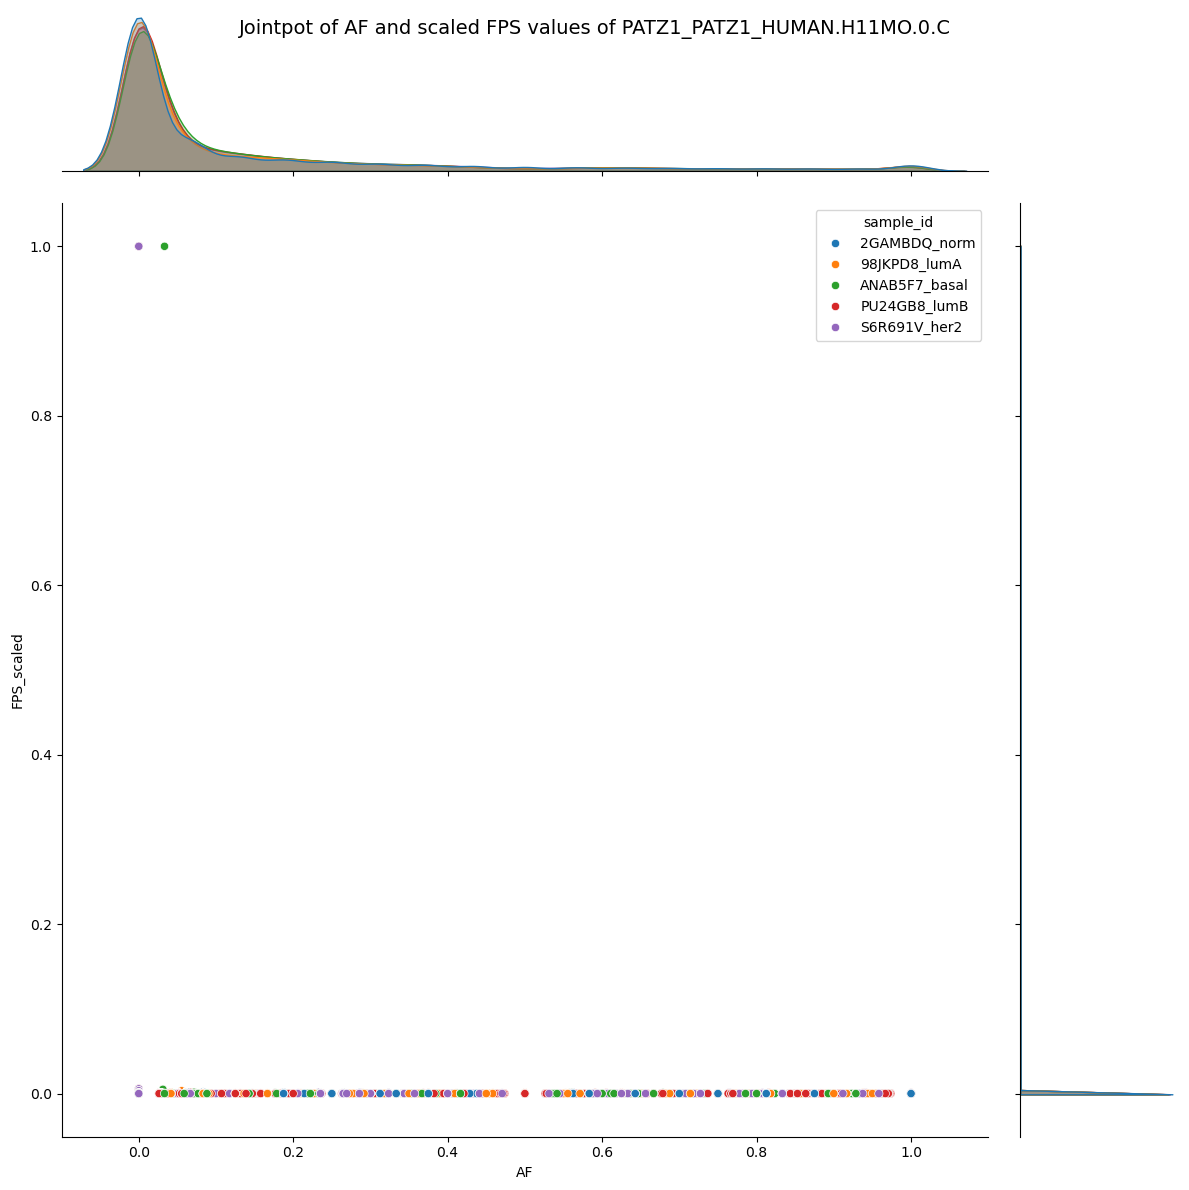

In [13]:
g = sns.jointplot(data=afps_full_dfl, x='AF', y='FPS_scaled', kind='scatter', hue='sample_id', height=12)
plt.xlim(-0.1, 1.1)
g.figure.suptitle(f"Jointpot of AF and scaled FPS values of {motif_id}", fontsize=14)

### Filtering Zero Sites

We should filter out the sites that have zero AF values in ALL subtypes, as these are not informative for our analysis. We will also filter out the sites that have zero FPS values in ALL subtypes.

In [14]:
afps_full_dfl

region_id      sample_id        AF  FPS  FPS_scaled
0             chr1:29434-29456   2GAMBDQ_norm  0.000000  0.0         0.0
1             chr1:29434-29456   98JKPD8_lumA  1.000000  0.0         0.0
2             chr1:29434-29456  ANAB5F7_basal  0.807692  0.0         0.0
3             chr1:29434-29456   PU24GB8_lumB  1.000000  0.0         0.0
4             chr1:29434-29456   S6R691V_her2  1.000000  0.0         0.0
...                        ...            ...       ...  ...         ...
573100  chrY:26671746-26671768   2GAMBDQ_norm  0.000000  0.0         0.0
573101  chrY:26671746-26671768   98JKPD8_lumA  0.000000  0.0         0.0
573102  chrY:26671746-26671768  ANAB5F7_basal  0.000000  0.0         0.0
573103  chrY:26671746-26671768   PU24GB8_lumB  0.500000  0.0         0.0
573104  chrY:26671746-26671768   S6R691V_her2  0.000000  0.0         0.0

[573105 rows x 5 columns]

`FPS` value `== 0` means that the raw FPS values across subtypes are zero, i.e. there is no evidence of footprinting at all at these sites despite a TFBS matching a motif being present (assigned by TOBIAS). AF value `== 0` means that there is no evidence of a variant genotype at these sites across the samples making up a subtype. 

In [15]:
# filter out unique region_id rows that have fps == 0 across the sample_ids and AF == 0
# group by 'region_id' first 
merged_filt_dfl = afps_full_dfl.groupby('region_id').filter(lambda x: x['FPS'].sum() > 0 and x['AF'].sum() > 0)
merged_filt_dfl

region_id      sample_id        AF      FPS  FPS_scaled
90          chr1:818770-818792   2GAMBDQ_norm  0.000000  0.03174    0.000004
91          chr1:818770-818792   98JKPD8_lumA  0.125000  0.02572    0.000004
92          chr1:818770-818792  ANAB5F7_basal  0.033333  0.02376    0.000004
93          chr1:818770-818792   PU24GB8_lumB  0.055556  0.02814    0.000004
94          chr1:818770-818792   S6R691V_her2  0.062500  0.02271    0.000003
...                        ...            ...       ...      ...         ...
572845  chrY:26403628-26403650   2GAMBDQ_norm  0.500000  0.01702    0.000002
572846  chrY:26403628-26403650   98JKPD8_lumA  0.277778  0.00908    0.000002
572847  chrY:26403628-26403650  ANAB5F7_basal  0.541667  0.00718    0.000001
572848  chrY:26403628-26403650   PU24GB8_lumB  1.000000  0.01526    0.000002
572849  chrY:26403628-26403650   S6R691V_her2  0.250000  0.01081    0.000002

[536060 rows x 5 columns]

### Calculating Variation Statistics
With the full data table cleaned up into a long format, we can now calculate the variation statistics for each region. We will calculate variance (Var).


A) First calculate statistics on the raw FPS data.

In [16]:
# extract fps columns
fps_df = dt_afps.filter(regex='_fps$|_id$').copy()
fps_df

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  \
0                    0.0                0.0               0.0   
1                    0.0                0.0               0.0   
2                    0.0                0.0               0.0   
3                    0.0                0.0               0.0   
4                    0.0                0.0               0.0   
...                  ...                ...               ...   
114616               0.0                0.0               0.0   
114617               0.0                0.0               0.0   
114618               0.0                0.0               0.0   
114619               0.0                0.0               0.0   
114620               0.0                0.0               0.0   

        PU24GB8_lumB_fps  2GAMBDQ_norm_fps               region_id  
0                    0.0               0.0        chr1:29434-29456  
1                    0.0               0.0      chr1:136931-136953  
2                    0.0               0.0      chr1:181521-181543  
3                    0.0               0.0      chr1:181572-181594  
4                    0.0               0.0      chr1:182780-182802  
...                  ...               ...                     ...  
114616               0.0               0.0  chrY:26671025-26671047  
114617               0.0               0.0  chrY:26671055-26671077  
114618               0.0               0.0  chrY:26671150-26671172  
114619               0.0               0.0  chrY:26671670-26671692  
114620               0.0               0.0  chrY:26671746-26671768  

[114621 rows x 6 columns]

Now filter out the rows whose `region_id` is not in the `region_id` column of `merged_filt`. First, reduce the repeated `region_id` column to unique values in `merged_filt`.

In [17]:
# this creates an array
merged_filt_uniq_region_id = merged_filt_dfl['region_id'].unique()

In [18]:
# then using this array, keep only the rows in the fps_df that have `region_id` values in the array
fps_df_filt = fps_df[fps_df['region_id'].isin(merged_filt_uniq_region_id)]
fps_df_filt

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  \
18               0.02572            0.02376           0.02271   
19               0.08751            0.06711           0.07205   
20               0.25518            0.18547           0.18792   
21               0.45331            0.34185           0.35194   
22               0.48515            0.34561           0.49185   
...                  ...                ...               ...   
114546           0.00501            0.00415           0.00631   
114566           0.01875            0.01190           0.01910   
114567           0.01863            0.01337           0.01827   
114568           0.01470            0.00732           0.01185   
114569           0.00908            0.00718           0.01081   

        PU24GB8_lumB_fps  2GAMBDQ_norm_fps               region_id  
18               0.02814           0.03174      chr1:818770-818792  
19               0.06268           0.06731      chr1:826708-826730  
20               0.19092           0.18877      chr1:827077-827099  
21               0.38722           0.33914      chr1:827249-827271  
22               0.50820           0.45281      chr1:827431-827453  
...                  ...               ...                     ...  
114546           0.01089           0.01126  chrY:11067896-11067918  
114566           0.01344           0.02912  chrY:26403188-26403210  
114567           0.02166           0.01893  chrY:26403279-26403301  
114568           0.01706           0.01515  chrY:26403400-26403422  
114569           0.01526           0.01702  chrY:26403628-26403650  

[107212 rows x 6 columns]

In [19]:
# calculate variance of fps values across samples per region_id and add to a new column called 'fps_var'
fps_df_filt_ind = fps_df_filt.set_index('region_id')
fps_df_filt_ind['FPS_var'] = fps_df_filt_ind.var(axis=1)

fps_df_filt_ind

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  \
region_id                                                                       
chr1:818770-818792               0.02572            0.02376           0.02271   
chr1:826708-826730               0.08751            0.06711           0.07205   
chr1:827077-827099               0.25518            0.18547           0.18792   
chr1:827249-827271               0.45331            0.34185           0.35194   
chr1:827431-827453               0.48515            0.34561           0.49185   
...                                  ...                ...               ...   
chrY:11067896-11067918           0.00501            0.00415           0.00631   
chrY:26403188-26403210           0.01875            0.01190           0.01910   
chrY:26403279-26403301           0.01863            0.01337           0.01827   
chrY:26403400-26403422           0.01470            0.00732           0.01185   
chrY:26403628-26403650           0.00908            0.00718           0.01081   

                        PU24GB8_lumB_fps  2GAMBDQ_norm_fps   FPS_var  
region_id                                                             
chr1:818770-818792               0.02814           0.03174  0.000013  
chr1:826708-826730               0.06268           0.06731  0.000093  
chr1:827077-827099               0.19092           0.18877  0.000899  
chr1:827249-827271               0.38722           0.33914  0.002299  
chr1:827431-827453               0.50820           0.45281  0.004263  
...                                  ...               ...       ...  
chrY:11067896-11067918           0.01089           0.01126  0.000011  
chrY:26403188-26403210           0.01344           0.02912  0.000046  
chrY:26403279-26403301           0.02166           0.01893  0.000009  
chrY:26403400-26403422           0.01706           0.01515  0.000014  
chrY:26403628-26403650           0.01526           0.01702  0.000017  

[107212 rows x 6 columns]

B) Then do the same on the fps scaled data.

Filter out the rows whose `region_id` is not in the `region_id` column of `merged_filt_scaled`.

In [20]:
fps_df_scaled

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                   
chr1:29434-29456                            0.0                       0.0   
chr1:136931-136953                          0.0                       0.0   
chr1:181521-181543                          0.0                       0.0   
chr1:181572-181594                          0.0                       0.0   
chr1:182780-182802                          0.0                       0.0   
...                                         ...                       ...   
chrY:26671025-26671047                      0.0                       0.0   
chrY:26671055-26671077                      0.0                       0.0   
chrY:26671150-26671172                      0.0                       0.0   
chrY:26671670-26671692                      0.0                       0.0   
chrY:26671746-26671768                      0.0                       0.0   

                        S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                  
chr1:29434-29456                            0.0                      0.0   
chr1:136931-136953                          0.0                      0.0   
chr1:181521-181543                          0.0                      0.0   
chr1:181572-181594                          0.0                      0.0   
chr1:182780-182802                          0.0                      0.0   
...                                         ...                      ...   
chrY:26671025-26671047                      0.0                      0.0   
chrY:26671055-26671077                      0.0                      0.0   
chrY:26671150-26671172                      0.0                      0.0   
chrY:26671670-26671692                      0.0                      0.0   
chrY:26671746-26671768                      0.0                      0.0   

                        2GAMBDQ_norm_fps_scaled  
region_id                                        
chr1:29434-29456                            0.0  
chr1:136931-136953                          0.0  
chr1:181521-181543                          0.0  
chr1:181572-181594                          0.0  
chr1:182780-182802                          0.0  
...                                         ...  
chrY:26671025-26671047                      0.0  
chrY:26671055-26671077                      0.0  
chrY:26671150-26671172                      0.0  
chrY:26671670-26671692                      0.0  
chrY:26671746-26671768                      0.0  

[114621 rows x 5 columns]

In [21]:
# region_id in the scaled df is already used as index, so filter by index
fps_df_scaled_filt = fps_df_scaled[fps_df_scaled.index.isin(merged_filt_uniq_region_id)]
fps_df_scaled_filt


98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                   
chr1:818770-818792                 4.312502e-06              3.845303e-06   
chr1:826708-826730                 1.467290e-05              1.086104e-05   
chr1:827077-827099                 4.278632e-05              3.001634e-05   
chr1:827249-827271                 7.600701e-05              5.532478e-05   
chr1:827431-827453                 8.134566e-05              5.593330e-05   
...                                         ...                       ...   
chrY:11067896-11067918             8.400325e-07              6.716333e-07   
chrY:26403188-26403210             3.143834e-06              1.925888e-06   
chrY:26403279-26403301             3.123714e-06              2.163792e-06   
chrY:26403400-26403422             2.464766e-06              1.184664e-06   
chrY:26403628-26403650             1.522454e-06              1.162007e-06   

                        S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                  
chr1:818770-818792                 3.366964e-06                 0.000004   
chr1:826708-826730                 1.068207e-05                 0.000008   
chr1:827077-827099                 2.786084e-05                 0.000026   
chr1:827249-827271                 5.217830e-05                 0.000052   
chr1:827431-827453                 7.292122e-05                 0.000069   
...                                         ...                      ...   
chrY:11067896-11067918             9.355147e-07                 0.000001   
chrY:26403188-26403210             2.831748e-06                 0.000002   
chrY:26403279-26403301             2.708693e-06                 0.000003   
chrY:26403400-26403422             1.756870e-06                 0.000002   
chrY:26403628-26403650             1.602681e-06                 0.000002   

                        2GAMBDQ_norm_fps_scaled  
region_id                                        
chr1:818770-818792                     0.000004  
chr1:826708-826730                     0.000008  
chr1:827077-827099                     0.000022  
chr1:827249-827271                     0.000039  
chr1:827431-827453                     0.000052  
...                                         ...  
chrY:11067896-11067918                 0.000001  
chrY:26403188-26403210                 0.000003  
chrY:26403279-26403301                 0.000002  
chrY:26403400-26403422                 0.000002  
chrY:26403628-26403650                 0.000002  

[107212 rows x 5 columns]

In [22]:
# copy the slice
fps_df_scaled_filt_ind = fps_df_scaled_filt.copy()
fps_df_scaled_filt_ind

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                   
chr1:818770-818792                 4.312502e-06              3.845303e-06   
chr1:826708-826730                 1.467290e-05              1.086104e-05   
chr1:827077-827099                 4.278632e-05              3.001634e-05   
chr1:827249-827271                 7.600701e-05              5.532478e-05   
chr1:827431-827453                 8.134566e-05              5.593330e-05   
...                                         ...                       ...   
chrY:11067896-11067918             8.400325e-07              6.716333e-07   
chrY:26403188-26403210             3.143834e-06              1.925888e-06   
chrY:26403279-26403301             3.123714e-06              2.163792e-06   
chrY:26403400-26403422             2.464766e-06              1.184664e-06   
chrY:26403628-26403650             1.522454e-06              1.162007e-06   

                        S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                  
chr1:818770-818792                 3.366964e-06                 0.000004   
chr1:826708-826730                 1.068207e-05                 0.000008   
chr1:827077-827099                 2.786084e-05                 0.000026   
chr1:827249-827271                 5.217830e-05                 0.000052   
chr1:827431-827453                 7.292122e-05                 0.000069   
...                                         ...                      ...   
chrY:11067896-11067918             9.355147e-07                 0.000001   
chrY:26403188-26403210             2.831748e-06                 0.000002   
chrY:26403279-26403301             2.708693e-06                 0.000003   
chrY:26403400-26403422             1.756870e-06                 0.000002   
chrY:26403628-26403650             1.602681e-06                 0.000002   

                        2GAMBDQ_norm_fps_scaled  
region_id                                        
chr1:818770-818792                     0.000004  
chr1:826708-826730                     0.000008  
chr1:827077-827099                     0.000022  
chr1:827249-827271                     0.000039  
chr1:827431-827453                     0.000052  
...                                         ...  
chrY:11067896-11067918                 0.000001  
chrY:26403188-26403210                 0.000003  
chrY:26403279-26403301                 0.000002  
chrY:26403400-26403422                 0.000002  
chrY:26403628-26403650                 0.000002  

[107212 rows x 5 columns]

In [23]:
# calculate variance of fps_scaled values across samples per region_id and add to a new column called 'fps_scaled_var'
fps_df_scaled_filt_ind['FPS_scaled_var'] = fps_df_scaled_filt_ind.var(axis=1)
fps_df_scaled_filt_ind

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                   
chr1:818770-818792                 4.312502e-06              3.845303e-06   
chr1:826708-826730                 1.467290e-05              1.086104e-05   
chr1:827077-827099                 4.278632e-05              3.001634e-05   
chr1:827249-827271                 7.600701e-05              5.532478e-05   
chr1:827431-827453                 8.134566e-05              5.593330e-05   
...                                         ...                       ...   
chrY:11067896-11067918             8.400325e-07              6.716333e-07   
chrY:26403188-26403210             3.143834e-06              1.925888e-06   
chrY:26403279-26403301             3.123714e-06              2.163792e-06   
chrY:26403400-26403422             2.464766e-06              1.184664e-06   
chrY:26403628-26403650             1.522454e-06              1.162007e-06   

                        S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                  
chr1:818770-818792                 3.366964e-06                 0.000004   
chr1:826708-826730                 1.068207e-05                 0.000008   
chr1:827077-827099                 2.786084e-05                 0.000026   
chr1:827249-827271                 5.217830e-05                 0.000052   
chr1:827431-827453                 7.292122e-05                 0.000069   
...                                         ...                      ...   
chrY:11067896-11067918             9.355147e-07                 0.000001   
chrY:26403188-26403210             2.831748e-06                 0.000002   
chrY:26403279-26403301             2.708693e-06                 0.000003   
chrY:26403400-26403422             1.756870e-06                 0.000002   
chrY:26403628-26403650             1.602681e-06                 0.000002   

                        2GAMBDQ_norm_fps_scaled  FPS_scaled_var  
region_id                                                        
chr1:818770-818792                     0.000004    1.189078e-13  
chr1:826708-826730                     0.000008    7.322682e-12  
chr1:827077-827099                     0.000022    6.344026e-11  
chr1:827249-827271                     0.000039    1.782695e-10  
chr1:827431-827453                     0.000052    1.468651e-10  
...                                         ...             ...  
chrY:11067896-11067918                 0.000001    1.098266e-13  
chrY:26403188-26403210                 0.000003    4.923197e-13  
chrY:26403279-26403301                 0.000002    1.911981e-13  
chrY:26403400-26403422                 0.000002    2.608675e-13  
chrY:26403628-26403650                 0.000002    1.304989e-13  

[107212 rows x 6 columns]

C) Now do the same for the AF data.

In [24]:
# Do the same for AF values
# extract af columns
af_df = dt_afps.filter(regex='_AF$|_id$')
af_df


2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  PU24GB8_lumB_AF  \
0              0.000000         1.000000          0.807692         1.000000   
1              0.125000         0.000000          0.058824         0.052632   
2              0.000000         0.125000          0.088235         0.052632   
3              0.000000         0.000000          0.000000         0.026316   
4              0.000000         0.222222          0.000000         0.083333   
...                 ...              ...               ...              ...   
114616         0.000000         0.125000          0.000000         0.000000   
114617         0.333333         0.000000          0.000000         0.125000   
114618         0.000000         0.000000          0.416667         0.200000   
114619         1.000000         0.000000          0.000000         0.000000   
114620         0.000000         0.000000          0.000000         0.500000   

        S6R691V_her2_AF               region_id  
0              1.000000        chr1:29434-29456  
1              0.000000      chr1:136931-136953  
2              0.117647      chr1:181521-181543  
3              0.117647      chr1:181572-181594  
4              0.000000      chr1:182780-182802  
...                 ...                     ...  
114616         0.000000  chrY:26671025-26671047  
114617         0.000000  chrY:26671055-26671077  
114618         0.285714  chrY:26671150-26671172  
114619         0.000000  chrY:26671670-26671692  
114620         0.000000  chrY:26671746-26671768  

[114621 rows x 6 columns]

In [25]:
# filter by region_id
af_df_filt = af_df[af_df['region_id'].isin(merged_filt_uniq_region_id)]
af_df_filt

2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  PU24GB8_lumB_AF  \
18               0.0000         0.125000          0.033333         0.055556   
19               0.0000         0.000000          0.000000         0.027778   
20               0.0625         0.041667          0.058824         0.052632   
21               0.9375         0.916667          0.794118         0.868421   
22               0.0000         0.125000          0.000000         0.026316   
...                 ...              ...               ...              ...   
114546           1.0000         0.900000          1.000000         0.961538   
114566           1.0000         0.944444          1.000000         1.000000   
114567           0.8750         0.954545          0.928571         1.000000   
114568           1.0000         0.950000          1.000000         1.000000   
114569           0.5000         0.277778          0.541667         1.000000   

        S6R691V_her2_AF               region_id  
18             0.062500      chr1:818770-818792  
19             0.000000      chr1:826708-826730  
20             0.058824      chr1:827077-827099  
21             0.882353      chr1:827249-827271  
22             0.058824      chr1:827431-827453  
...                 ...                     ...  
114546         1.000000  chrY:11067896-11067918  
114566         0.958333  chrY:26403188-26403210  
114567         0.933333  chrY:26403279-26403301  
114568         1.000000  chrY:26403400-26403422  
114569         0.250000  chrY:26403628-26403650  

[107212 rows x 6 columns]

In [26]:
af_df_filt_ind = af_df_filt.set_index('region_id')
# then calculate variance of af values across samples per region_id and add to a new column called 'af_var'
af_df_filt_ind['AF_var'] = af_df_filt_ind.var(axis=1)
af_df_filt_ind

2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  \
region_id                                                                    
chr1:818770-818792               0.0000         0.125000          0.033333   
chr1:826708-826730               0.0000         0.000000          0.000000   
chr1:827077-827099               0.0625         0.041667          0.058824   
chr1:827249-827271               0.9375         0.916667          0.794118   
chr1:827431-827453               0.0000         0.125000          0.000000   
...                                 ...              ...               ...   
chrY:11067896-11067918           1.0000         0.900000          1.000000   
chrY:26403188-26403210           1.0000         0.944444          1.000000   
chrY:26403279-26403301           0.8750         0.954545          0.928571   
chrY:26403400-26403422           1.0000         0.950000          1.000000   
chrY:26403628-26403650           0.5000         0.277778          0.541667   

                        PU24GB8_lumB_AF  S6R691V_her2_AF    AF_var  
region_id                                                           
chr1:818770-818792             0.055556         0.062500  0.002113  
chr1:826708-826730             0.027778         0.000000  0.000154  
chr1:827077-827099             0.052632         0.058824  0.000067  
chr1:827249-827271             0.868421         0.882353  0.003041  
chr1:827431-827453             0.026316         0.058824  0.002737  
...                                 ...              ...       ...  
chrY:11067896-11067918         0.961538         1.000000  0.001911  
chrY:26403188-26403210         1.000000         0.958333  0.000733  
chrY:26403279-26403301         1.000000         0.933333  0.002049  
chrY:26403400-26403422         1.000000         1.000000  0.000500  
chrY:26403628-26403650         1.000000         0.250000  0.090664  

[107212 rows x 6 columns]

D) Now merge the statistics tables together on `region_id` index.

In [27]:
fps_filt_var = fps_df_filt_ind.filter(regex='_var$|_id$').copy()
fps_filt_var

FPS_var
region_id                       
chr1:818770-818792      0.000013
chr1:826708-826730      0.000093
chr1:827077-827099      0.000899
chr1:827249-827271      0.002299
chr1:827431-827453      0.004263
...                          ...
chrY:11067896-11067918  0.000011
chrY:26403188-26403210  0.000046
chrY:26403279-26403301  0.000009
chrY:26403400-26403422  0.000014
chrY:26403628-26403650  0.000017

[107212 rows x 1 columns]

In [28]:
fps_sc_filt_var = fps_df_scaled_filt_ind.filter(regex='_var$|_id$').copy()
af_filt_var = af_df_filt_ind.filter(regex='_var$|_id$').copy()
# merge on region_id index from both tables
merged_var_tmp = fps_filt_var.merge(fps_sc_filt_var, left_index=True, right_index=True)
# now merge with af_df
merged_var = merged_var_tmp.merge(af_filt_var, left_index=True, right_index=True)
merged_var

FPS_var  FPS_scaled_var    AF_var
region_id                                                 
chr1:818770-818792      0.000013    1.189078e-13  0.002113
chr1:826708-826730      0.000093    7.322682e-12  0.000154
chr1:827077-827099      0.000899    6.344026e-11  0.000067
chr1:827249-827271      0.002299    1.782695e-10  0.003041
chr1:827431-827453      0.004263    1.468651e-10  0.002737
...                          ...             ...       ...
chrY:11067896-11067918  0.000011    1.098266e-13  0.001911
chrY:26403188-26403210  0.000046    4.923197e-13  0.000733
chrY:26403279-26403301  0.000009    1.911981e-13  0.002049
chrY:26403400-26403422  0.000014    2.608675e-13  0.000500
chrY:26403628-26403650  0.000017    1.304989e-13  0.090664

[107212 rows x 3 columns]

Now we have a table of stats data to merge with the `merge_filt` raw data.

In [29]:
# set the index to 'region_id'
merged_filt_i = merged_filt_dfl.set_index('region_id')
merged_filt_i

sample_id        AF      FPS  FPS_scaled
region_id                                                           
chr1:818770-818792       2GAMBDQ_norm  0.000000  0.03174    0.000004
chr1:818770-818792       98JKPD8_lumA  0.125000  0.02572    0.000004
chr1:818770-818792      ANAB5F7_basal  0.033333  0.02376    0.000004
chr1:818770-818792       PU24GB8_lumB  0.055556  0.02814    0.000004
chr1:818770-818792       S6R691V_her2  0.062500  0.02271    0.000003
...                               ...       ...      ...         ...
chrY:26403628-26403650   2GAMBDQ_norm  0.500000  0.01702    0.000002
chrY:26403628-26403650   98JKPD8_lumA  0.277778  0.00908    0.000002
chrY:26403628-26403650  ANAB5F7_basal  0.541667  0.00718    0.000001
chrY:26403628-26403650   PU24GB8_lumB  1.000000  0.01526    0.000002
chrY:26403628-26403650   S6R691V_her2  0.250000  0.01081    0.000002

[536060 rows x 4 columns]

In [30]:
# merge afps_full_dfli with stats df on region_id
merged_stat = merged_filt_i.merge(merged_var, left_index=True, right_index=True, how='left')
merged_stat


sample_id        AF      FPS  FPS_scaled  \
region_id                                                              
chr1:818770-818792       2GAMBDQ_norm  0.000000  0.03174    0.000004   
chr1:818770-818792       98JKPD8_lumA  0.125000  0.02572    0.000004   
chr1:818770-818792      ANAB5F7_basal  0.033333  0.02376    0.000004   
chr1:818770-818792       PU24GB8_lumB  0.055556  0.02814    0.000004   
chr1:818770-818792       S6R691V_her2  0.062500  0.02271    0.000003   
...                               ...       ...      ...         ...   
chrY:26403628-26403650   2GAMBDQ_norm  0.500000  0.01702    0.000002   
chrY:26403628-26403650   98JKPD8_lumA  0.277778  0.00908    0.000002   
chrY:26403628-26403650  ANAB5F7_basal  0.541667  0.00718    0.000001   
chrY:26403628-26403650   PU24GB8_lumB  1.000000  0.01526    0.000002   
chrY:26403628-26403650   S6R691V_her2  0.250000  0.01081    0.000002   

                         FPS_var  FPS_scaled_var    AF_var  
region_id                                                   
chr1:818770-818792      0.000013    1.189078e-13  0.002113  
chr1:818770-818792      0.000013    1.189078e-13  0.002113  
chr1:818770-818792      0.000013    1.189078e-13  0.002113  
chr1:818770-818792      0.000013    1.189078e-13  0.002113  
chr1:818770-818792      0.000013    1.189078e-13  0.002113  
...                          ...             ...       ...  
chrY:26403628-26403650  0.000017    1.304989e-13  0.090664  
chrY:26403628-26403650  0.000017    1.304989e-13  0.090664  
chrY:26403628-26403650  0.000017    1.304989e-13  0.090664  
chrY:26403628-26403650  0.000017    1.304989e-13  0.090664  
chrY:26403628-26403650  0.000017    1.304989e-13  0.090664  

[536060 rows x 7 columns]

In [31]:
# drop the FPS and FPS_var columns
merged_stat = merged_stat.drop(columns=merged_stat.filter(regex='FPS_var|FPS$').columns)
merged_stat

sample_id        AF  FPS_scaled  FPS_scaled_var  \
region_id                                                                     
chr1:818770-818792       2GAMBDQ_norm  0.000000    0.000004    1.189078e-13   
chr1:818770-818792       98JKPD8_lumA  0.125000    0.000004    1.189078e-13   
chr1:818770-818792      ANAB5F7_basal  0.033333    0.000004    1.189078e-13   
chr1:818770-818792       PU24GB8_lumB  0.055556    0.000004    1.189078e-13   
chr1:818770-818792       S6R691V_her2  0.062500    0.000003    1.189078e-13   
...                               ...       ...         ...             ...   
chrY:26403628-26403650   2GAMBDQ_norm  0.500000    0.000002    1.304989e-13   
chrY:26403628-26403650   98JKPD8_lumA  0.277778    0.000002    1.304989e-13   
chrY:26403628-26403650  ANAB5F7_basal  0.541667    0.000001    1.304989e-13   
chrY:26403628-26403650   PU24GB8_lumB  1.000000    0.000002    1.304989e-13   
chrY:26403628-26403650   S6R691V_her2  0.250000    0.000002    1.304989e-13   

                          AF_var  
region_id                         
chr1:818770-818792      0.002113  
chr1:818770-818792      0.002113  
chr1:818770-818792      0.002113  
chr1:818770-818792      0.002113  
chr1:818770-818792      0.002113  
...                          ...  
chrY:26403628-26403650  0.090664  
chrY:26403628-26403650  0.090664  
chrY:26403628-26403650  0.090664  
chrY:26403628-26403650  0.090664  
chrY:26403628-26403650  0.090664  

[536060 rows x 5 columns]

In [32]:
# rearrange columns
merged_stat = merged_stat[['sample_id', 'AF', 'FPS_scaled', 'AF_var', 'FPS_scaled_var']]
merged_stat

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                               
chr1:818770-818792       2GAMBDQ_norm  0.000000    0.000004  0.002113   
chr1:818770-818792       98JKPD8_lumA  0.125000    0.000004  0.002113   
chr1:818770-818792      ANAB5F7_basal  0.033333    0.000004  0.002113   
chr1:818770-818792       PU24GB8_lumB  0.055556    0.000004  0.002113   
chr1:818770-818792       S6R691V_her2  0.062500    0.000003  0.002113   
...                               ...       ...         ...       ...   
chrY:26403628-26403650   2GAMBDQ_norm  0.500000    0.000002  0.090664   
chrY:26403628-26403650   98JKPD8_lumA  0.277778    0.000002  0.090664   
chrY:26403628-26403650  ANAB5F7_basal  0.541667    0.000001  0.090664   
chrY:26403628-26403650   PU24GB8_lumB  1.000000    0.000002  0.090664   
chrY:26403628-26403650   S6R691V_her2  0.250000    0.000002  0.090664   

                        FPS_scaled_var  
region_id                               
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
...                                ...  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  

[536060 rows x 5 columns]

#### ASIDE: Visualizing `AF_var` and `FPS_scaled_var`
We can now see if there is a correlation between the variance of the AF and FPS values, per `region_id`. As the statistics are calculated per `region_id`, we can plot the `FPS_scaled_var` and `AF_var` values against each other.

In [33]:
# subset a copy of the dataframe with only the AF_var and FPS_scaled_var columns and region_id
merged_stat_vars = merged_stat[['AF_var', 'FPS_scaled_var']].copy().drop_duplicates()
merged_stat_vars

AF_var  FPS_scaled_var
region_id                                       
chr1:818770-818792      0.002113    1.189078e-13
chr1:826708-826730      0.000154    7.322682e-12
chr1:827077-827099      0.000067    6.344026e-11
chr1:827249-827271      0.003041    1.782695e-10
chr1:827431-827453      0.002737    1.468651e-10
...                          ...             ...
chrY:11067896-11067918  0.001911    1.098266e-13
chrY:26403188-26403210  0.000733    4.923197e-13
chrY:26403279-26403301  0.002049    1.911981e-13
chrY:26403400-26403422  0.000500    2.608675e-13
chrY:26403628-26403650  0.090664    1.304989e-13

[107211 rows x 2 columns]

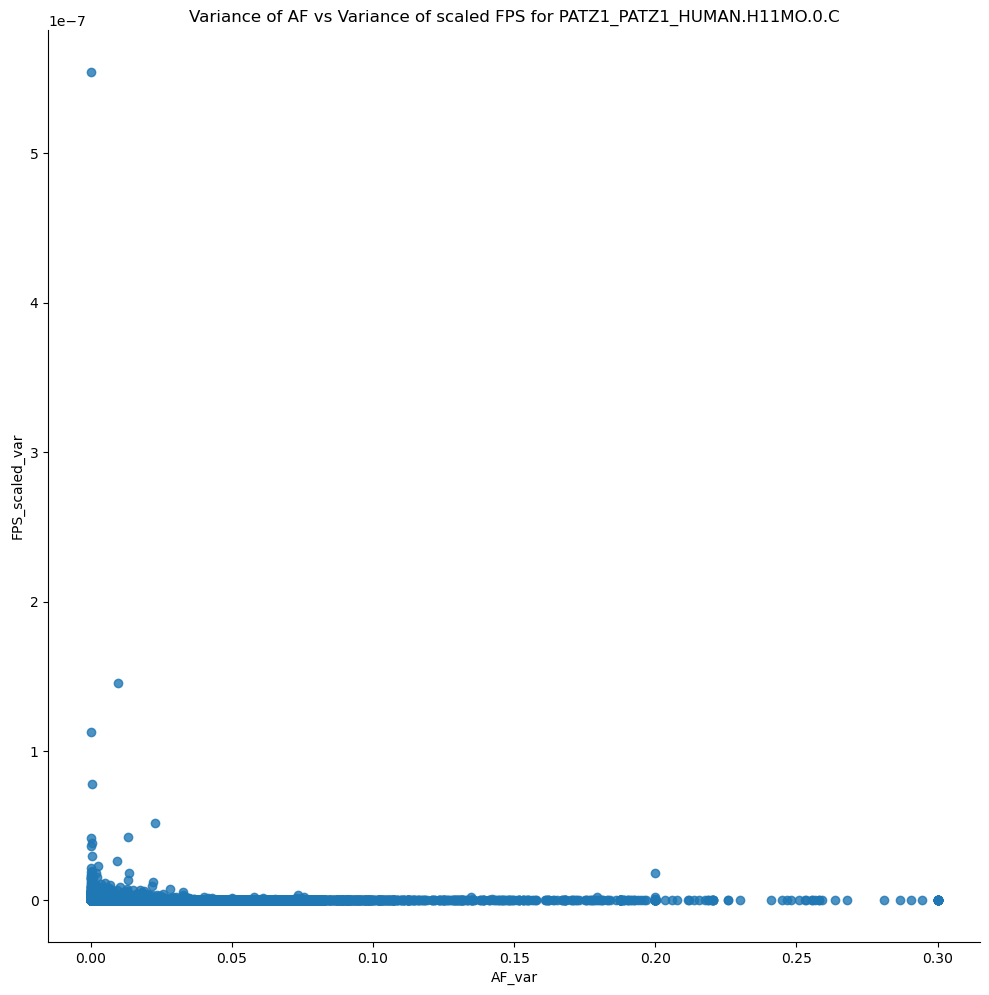

In [34]:
# plot lmplot
sns.lmplot(data=merged_stat_vars, x='AF_var', y='FPS_scaled_var', fit_reg=False, height=10)
plt.title(f'Variance of AF vs Variance of scaled FPS for {motif_id}')
plt.show()

### Finding Covariant Sites 

Now that `merged_stat` contains the variance statistics for both AF and FPS values, we can find the sites that have high variance in both AF and FPS values. We can do this by filtering the `merged_stat` table to include only the rows where both `AF_var` and `FPS_scaled_var` are above a certain threshold.

To remove arbitrariness, **IQR outlier method** can be used to find the threshold for high variance.

In [35]:
merged_stat

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                               
chr1:818770-818792       2GAMBDQ_norm  0.000000    0.000004  0.002113   
chr1:818770-818792       98JKPD8_lumA  0.125000    0.000004  0.002113   
chr1:818770-818792      ANAB5F7_basal  0.033333    0.000004  0.002113   
chr1:818770-818792       PU24GB8_lumB  0.055556    0.000004  0.002113   
chr1:818770-818792       S6R691V_her2  0.062500    0.000003  0.002113   
...                               ...       ...         ...       ...   
chrY:26403628-26403650   2GAMBDQ_norm  0.500000    0.000002  0.090664   
chrY:26403628-26403650   98JKPD8_lumA  0.277778    0.000002  0.090664   
chrY:26403628-26403650  ANAB5F7_basal  0.541667    0.000001  0.090664   
chrY:26403628-26403650   PU24GB8_lumB  1.000000    0.000002  0.090664   
chrY:26403628-26403650   S6R691V_her2  0.250000    0.000002  0.090664   

                        FPS_scaled_var  
region_id                               
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
chr1:818770-818792        1.189078e-13  
...                                ...  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  
chrY:26403628-26403650    1.304989e-13  

[536060 rows x 5 columns]

In [36]:
# subset the dataframe to only include the AF_var and FPS_scaled_var columns and keep only unique rows
merged_stat_vars = merged_stat[['AF_var', 'FPS_scaled_var']].copy().drop_duplicates()
merged_stat_vars

AF_var  FPS_scaled_var
region_id                                       
chr1:818770-818792      0.002113    1.189078e-13
chr1:826708-826730      0.000154    7.322682e-12
chr1:827077-827099      0.000067    6.344026e-11
chr1:827249-827271      0.003041    1.782695e-10
chr1:827431-827453      0.002737    1.468651e-10
...                          ...             ...
chrY:11067896-11067918  0.001911    1.098266e-13
chrY:26403188-26403210  0.000733    4.923197e-13
chrY:26403279-26403301  0.002049    1.911981e-13
chrY:26403400-26403422  0.000500    2.608675e-13
chrY:26403628-26403650  0.090664    1.304989e-13

[107211 rows x 2 columns]

We can plot boxplots to visualize the distribution of `AF_var` and `FPS_scaled_var` values.

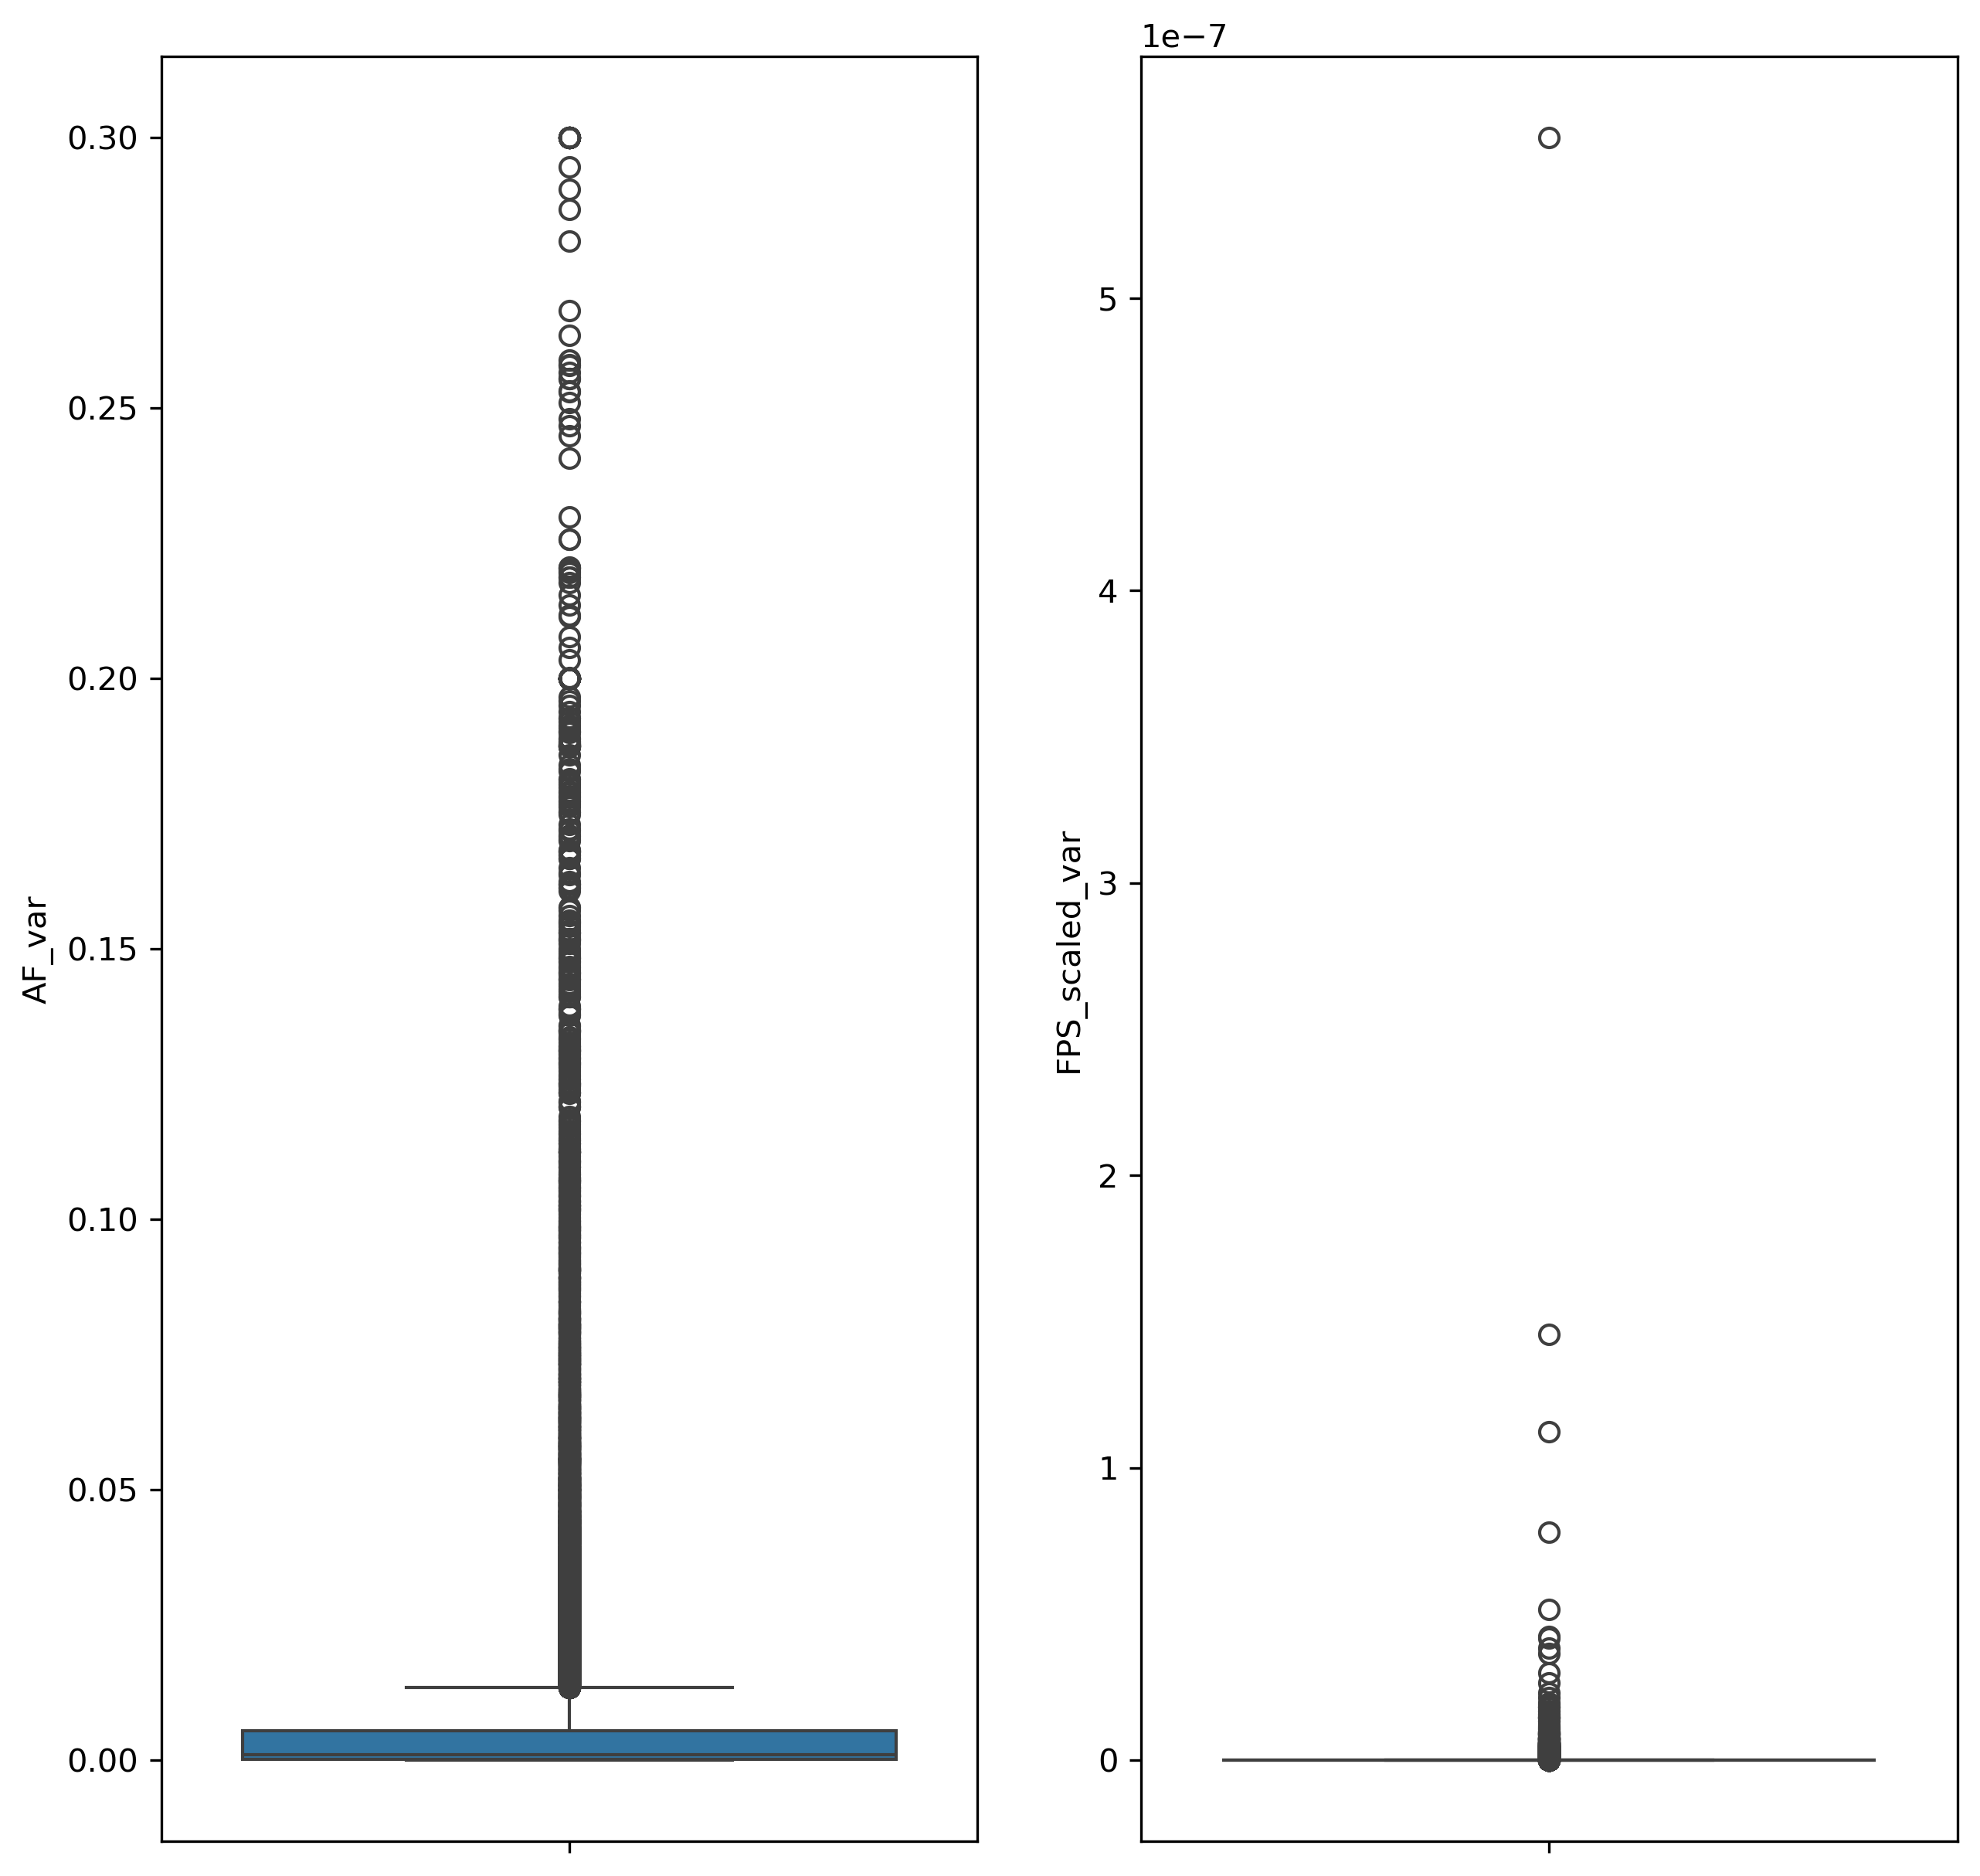

In [37]:
# plot bloxplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300)
sns.boxplot(data=merged_stat_vars, y='AF_var', ax=axs[0])
sns.boxplot(data=merged_stat_vars, y='FPS_scaled_var', ax=axs[1])
plt.show()

The distribution is highly skewed and we are looking at variances, not raw data points, so we can probably ignore the lower bounds and just use the upper bounds as the threshold to filter for potentially interesting sites. 




Calculate the distribution of `AF_var` and `FPS_scaled_var` values and then calculate the IQR for each. Then, calculate the upper and lower bounds for the `AF_var` and `FPS_scaled_var` values.

In [38]:
# Calculate the IQR for AF_var and FPS_scaled_var separately

q1_vaf = merged_stat_vars['AF_var'].quantile(0.25)
q3_vaf = merged_stat_vars['AF_var'].quantile(0.75)
iqr_vaf = q3_vaf - q1_vaf
lower_bound_outliers_vaf = q1_vaf - (1.5 * iqr_vaf)
upper_bound_outliers_vaf = q3_vaf + (1.5 * iqr_vaf)

# calculate IQR for FPS_scaled_var
q1_vfps = merged_stat_vars['FPS_scaled_var'].quantile(0.25)
q3_vfps = merged_stat_vars['FPS_scaled_var'].quantile(0.75)
iqr_vfps = q3_vfps - q1_vfps
lower_bound_outliers_vfps = q1_vfps - (1.5 * iqr_vfps)
upper_bound_outliers_vfps = q3_vfps + (1.5 * iqr_vfps)

print(f'Outlier bounds for {motif_id} AF variance: {lower_bound_outliers_vaf, upper_bound_outliers_vaf}')

print(f'Outlier bounds for {motif_id} FPS_scaled variance: {lower_bound_outliers_vfps, upper_bound_outliers_vfps}')

Outlier bounds for PATZ1_PATZ1_HUMAN.H11MO.0.C AF variance: (-0.007695611054455001, 0.013506291077153)
Outlier bounds for PATZ1_PATZ1_HUMAN.H11MO.0.C FPS_scaled variance: (-2.0640440203651034e-11, 3.547674236372588e-11)


In [39]:
# using the outlier fence of upper bound, get the region_id that are outliers for both AF_var and FPS_scaled_var
outlier_af_fps_vars = merged_stat_vars[(merged_stat_vars['AF_var'] > upper_bound_outliers_vaf) & (merged_stat_vars['FPS_scaled_var'] > upper_bound_outliers_vfps)]

outlier_af_fps_vars

AF_var  FPS_scaled_var
region_id                                         
chr1:940284-940306        0.035672    2.210321e-10
chr1:976855-976877        0.200000    1.105404e-10
chr1:977045-977067        0.036731    8.001031e-10
chr1:977140-977162        0.054492    4.965610e-11
chr1:977172-977194        0.200000    9.440495e-11
...                            ...             ...
chrX:134670011-134670033  0.030500    6.554846e-11
chrX:135021855-135021877  0.016125    5.896980e-10
chrX:153944721-153944743  0.019553    6.924199e-11
chrX:154341580-154341602  0.026304    6.450501e-11
chrY:7362241-7362263      0.200000    5.072633e-10

[1301 rows x 2 columns]

In [40]:
# now extract the unique region IDs as a list from the outlier_af_fps_vars
outliers_list = outlier_af_fps_vars.index.tolist()

# subset the merged_stat dataframe to get the highly covariant sites (outlier sites)
covar_sites = merged_stat[merged_stat.index.isin(outliers_list)]

covar_sites

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                             
chr1:940284-940306     2GAMBDQ_norm  0.562500    0.000030  0.035672   
chr1:940284-940306     98JKPD8_lumA  0.625000    0.000057  0.035672   
chr1:940284-940306    ANAB5F7_basal  1.000000    0.000032  0.035672   
chr1:940284-940306     PU24GB8_lumB  0.710526    0.000034  0.035672   
chr1:940284-940306     S6R691V_her2  0.529412    0.000061  0.035672   
...                             ...       ...         ...       ...   
chrY:7362241-7362263   2GAMBDQ_norm  0.000000    0.000264  0.200000   
chrY:7362241-7362263   98JKPD8_lumA  0.000000    0.000300  0.200000   
chrY:7362241-7362263  ANAB5F7_basal  0.000000    0.000327  0.200000   
chrY:7362241-7362263   PU24GB8_lumB  0.000000    0.000290  0.200000   
chrY:7362241-7362263   S6R691V_her2  1.000000    0.000301  0.200000   

                      FPS_scaled_var  
region_id                             
chr1:940284-940306      2.210321e-10  
chr1:940284-940306      2.210321e-10  
chr1:940284-940306      2.210321e-10  
chr1:940284-940306      2.210321e-10  
chr1:940284-940306      2.210321e-10  
...                              ...  
chrY:7362241-7362263    5.072633e-10  
chrY:7362241-7362263    5.072633e-10  
chrY:7362241-7362263    5.072633e-10  
chrY:7362241-7362263    5.072633e-10  
chrY:7362241-7362263    5.072633e-10  

[6505 rows x 5 columns]

In [41]:
# sort the outlier sites by descending order of AF_var and FPS_scaled_var
covar_sites_sorted = covar_sites.sort_values(by=['AF_var', 'FPS_scaled_var'], ascending=[False, False])
covar_sites_sorted

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                               
chr1:977392-977414       2GAMBDQ_norm  1.000000    0.000028  0.300000   
chr1:977392-977414       98JKPD8_lumA  0.000000    0.000038  0.300000   
chr1:977392-977414      ANAB5F7_basal  0.000000    0.000016  0.300000   
chr1:977392-977414       PU24GB8_lumB  1.000000    0.000033  0.300000   
chr1:977392-977414       S6R691V_her2  0.000000    0.000019  0.300000   
...                               ...       ...         ...       ...   
chr5:34245305-34245327   2GAMBDQ_norm  1.000000    0.000053  0.013517   
chr5:34245305-34245327   98JKPD8_lumA  1.000000    0.000085  0.013517   
chr5:34245305-34245327  ANAB5F7_basal  0.781250    0.000063  0.013517   
chr5:34245305-34245327   PU24GB8_lumB  0.764706    0.000080  0.013517   
chr5:34245305-34245327   S6R691V_her2  0.941176    0.000082  0.013517   

                        FPS_scaled_var  
region_id                               
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
...                                ...  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  

[6505 rows x 5 columns]

We can plot to see the distributions.

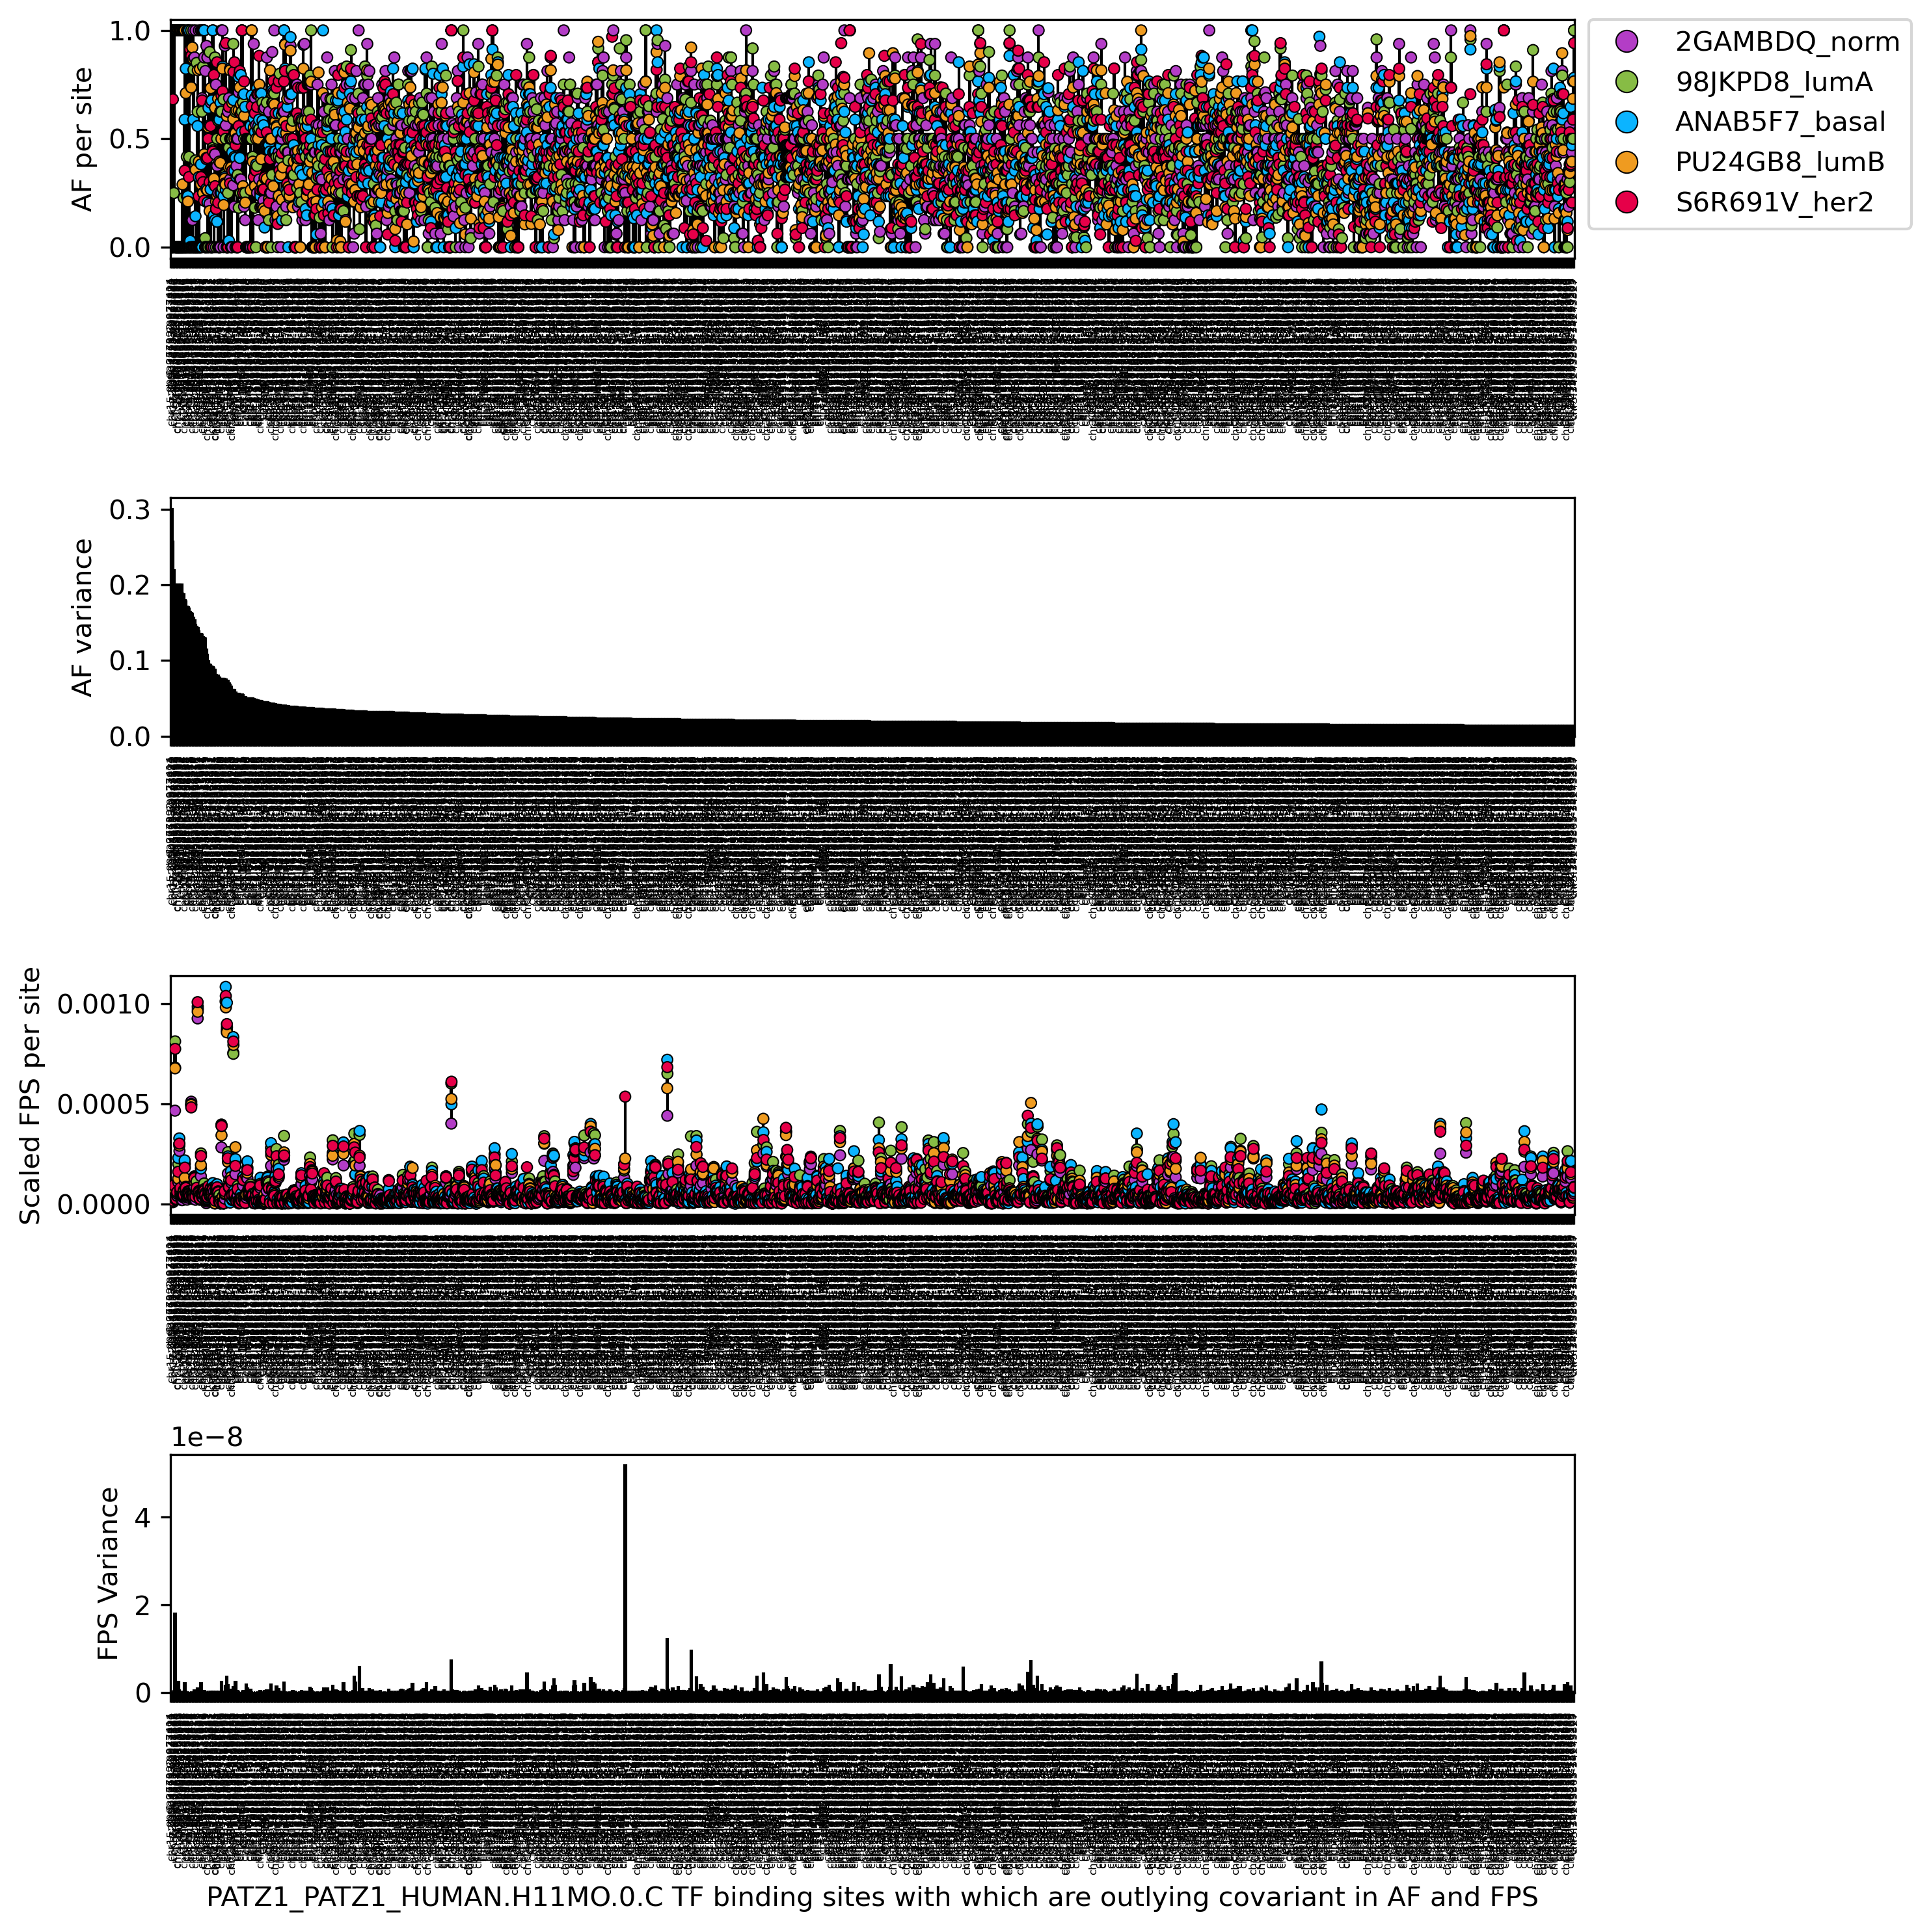

In [42]:
# create color dictionary
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=covar_sites_sorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=covar_sites_sorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF per site', fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=covar_sites_sorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF variance', fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=covar_sites_sorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=covar_sites_sorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('Scaled FPS per site', fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=covar_sites_sorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with which are outlying covariant in AF and FPS', fontsize=10)
plt.ylabel('FPS Variance', fontsize=10)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

We can plot `lmplot` hued by `sample_id` to see if there are any patterns in the raw data.

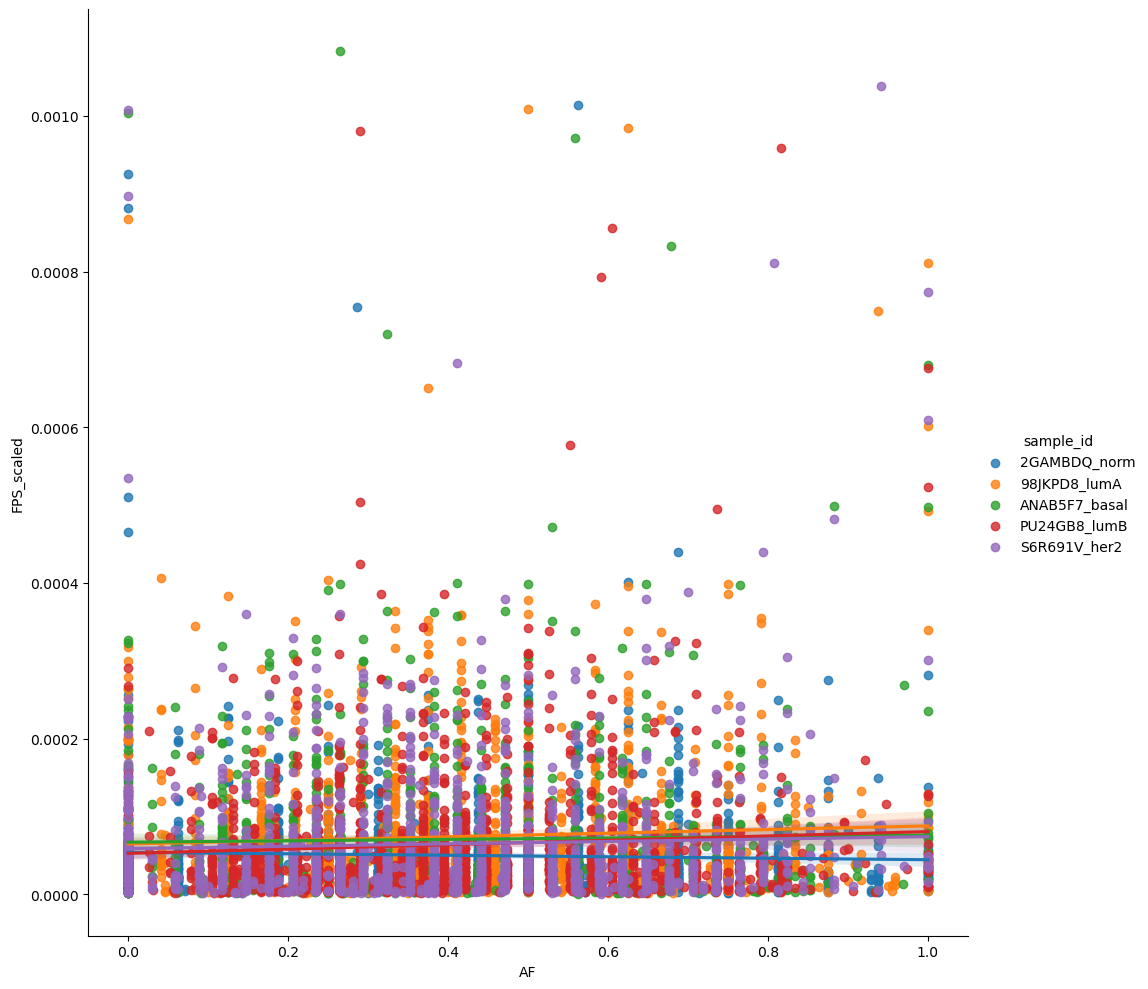

In [43]:
# plot jointplot of site_counts_sorted_top5
sns.lmplot(x='AF', y='FPS_scaled', data=covar_sites_sorted, hue='sample_id', fit_reg=True, height=10)

In [44]:
# test for correlation between AF and FPS_scaled for each subtype
from scipy.stats import spearmanr

covar_sites_sorted

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                               
chr1:977392-977414       2GAMBDQ_norm  1.000000    0.000028  0.300000   
chr1:977392-977414       98JKPD8_lumA  0.000000    0.000038  0.300000   
chr1:977392-977414      ANAB5F7_basal  0.000000    0.000016  0.300000   
chr1:977392-977414       PU24GB8_lumB  1.000000    0.000033  0.300000   
chr1:977392-977414       S6R691V_her2  0.000000    0.000019  0.300000   
...                               ...       ...         ...       ...   
chr5:34245305-34245327   2GAMBDQ_norm  1.000000    0.000053  0.013517   
chr5:34245305-34245327   98JKPD8_lumA  1.000000    0.000085  0.013517   
chr5:34245305-34245327  ANAB5F7_basal  0.781250    0.000063  0.013517   
chr5:34245305-34245327   PU24GB8_lumB  0.764706    0.000080  0.013517   
chr5:34245305-34245327   S6R691V_her2  0.941176    0.000082  0.013517   

                        FPS_scaled_var  
region_id                               
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
chr1:977392-977414        8.471394e-11  
...                                ...  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  
chr5:34245305-34245327    1.998190e-10  

[6505 rows x 5 columns]

In [45]:
covar_sites_sorted_novars = covar_sites_sorted.drop(columns=['AF_var', 'FPS_scaled_var'])
covar_sites_sorted_novars

sample_id        AF  FPS_scaled
region_id                                                  
chr1:977392-977414       2GAMBDQ_norm  1.000000    0.000028
chr1:977392-977414       98JKPD8_lumA  0.000000    0.000038
chr1:977392-977414      ANAB5F7_basal  0.000000    0.000016
chr1:977392-977414       PU24GB8_lumB  1.000000    0.000033
chr1:977392-977414       S6R691V_her2  0.000000    0.000019
...                               ...       ...         ...
chr5:34245305-34245327   2GAMBDQ_norm  1.000000    0.000053
chr5:34245305-34245327   98JKPD8_lumA  1.000000    0.000085
chr5:34245305-34245327  ANAB5F7_basal  0.781250    0.000063
chr5:34245305-34245327   PU24GB8_lumB  0.764706    0.000080
chr5:34245305-34245327   S6R691V_her2  0.941176    0.000082

[6505 rows x 3 columns]

In [46]:
# reset index to make region_id a column
covar_sites_sorted_novars = covar_sites_sorted_novars.reset_index()
covar_sites_sorted_novars

region_id      sample_id        AF  FPS_scaled
0         chr1:977392-977414   2GAMBDQ_norm  1.000000    0.000028
1         chr1:977392-977414   98JKPD8_lumA  0.000000    0.000038
2         chr1:977392-977414  ANAB5F7_basal  0.000000    0.000016
3         chr1:977392-977414   PU24GB8_lumB  1.000000    0.000033
4         chr1:977392-977414   S6R691V_her2  0.000000    0.000019
...                      ...            ...       ...         ...
6500  chr5:34245305-34245327   2GAMBDQ_norm  1.000000    0.000053
6501  chr5:34245305-34245327   98JKPD8_lumA  1.000000    0.000085
6502  chr5:34245305-34245327  ANAB5F7_basal  0.781250    0.000063
6503  chr5:34245305-34245327   PU24GB8_lumB  0.764706    0.000080
6504  chr5:34245305-34245327   S6R691V_her2  0.941176    0.000082

[6505 rows x 4 columns]

#### Spearman Correlation Test between AF and scaled FPS

We can group the data table by `region_id` then find Spearman correlation based on this grouping. 

In [47]:
# Group by 'region_id' and calculate the correlation between AF and FPS_scaled for each group
correlations = covar_sites_sorted_novars.groupby('region_id').apply(lambda group: spearmanr(group['AF'], group['FPS_scaled']), include_groups=False)
correlations

region_id
chr10:100998579-100998601                    (-0.7, 0.18812040437418728)
chr10:102119295-102119317    (-0.46169025843831935, 0.43376615616902786)
chr10:102395099-102395121                     (0.6, 0.28475697986529375)
chr10:102918122-102918144      (0.35909242322980395, 0.5528147466433505)
chr10:103193317-103193339                      (0.3, 0.6238376647810728)
                                                ...                     
chrX:47233766-47233788         (0.5642880936468347, 0.32172333582430024)
chrX:49191151-49191173        (-0.39999999999999997, 0.5046315754686911)
chrX:53434405-53434427          (0.19999999999999998, 0.747060078104662)
chrX:72554499-72554521        (-0.09999999999999999, 0.8728885715695383)
chrY:7362241-7362263           (0.35355339059327373, 0.5594043441634877)
Length: 1301, dtype: object

In [48]:
# that returned a pandas Series, so convert to dataframe
correlations_df = pd.DataFrame(correlations, columns=['corr_coeff_and_pvalue'])
# split the 'corr_coeff_and_pvalue' column into two separate columns using apply() and pd.Series
correlations_df[['corr_coeff', 'pvalue']] = correlations_df['corr_coeff_and_pvalue'].apply(pd.Series)
# drop the original column
correlations_df = correlations_df.drop(columns=['corr_coeff_and_pvalue']).reset_index()
correlations_df

region_id  corr_coeff    pvalue
0     chr10:100998579-100998601   -0.700000  0.188120
1     chr10:102119295-102119317   -0.461690  0.433766
2     chr10:102395099-102395121    0.600000  0.284757
3     chr10:102918122-102918144    0.359092  0.552815
4     chr10:103193317-103193339    0.300000  0.623838
...                         ...         ...       ...
1296     chrX:47233766-47233788    0.564288  0.321723
1297     chrX:49191151-49191173   -0.400000  0.504632
1298     chrX:53434405-53434427    0.200000  0.747060
1299     chrX:72554499-72554521   -0.100000  0.872889
1300       chrY:7362241-7362263    0.353553  0.559404

[1301 rows x 3 columns]

In [49]:
# now sort region_id naturally
correlations_df_srt = correlations_df.reindex(index=index_natsorted(correlations_df['region_id']))
corr_df = correlations_df_srt.reset_index(drop=True)
corr_df

region_id  corr_coeff        pvalue
0           chr1:940284-940306   -0.400000  5.046316e-01
1           chr1:976855-976877    0.353553  5.594043e-01
2           chr1:977045-977067    1.000000  1.404265e-24
3           chr1:977140-977162    0.447214  4.501849e-01
4           chr1:977172-977194    0.000000  1.000000e+00
...                        ...         ...           ...
1296  chrX:134670011-134670033   -0.359092  5.528147e-01
1297  chrX:135021855-135021877    0.400000  5.046316e-01
1298  chrX:153944721-153944743   -0.700000  1.881204e-01
1299  chrX:154341580-154341602    0.666886  2.188940e-01
1300      chrY:7362241-7362263    0.353553  5.594043e-01

[1301 rows x 3 columns]

In [50]:
# filter for pvalue < 0.05
corr_df_sig = corr_df[corr_df['pvalue'] < 0.05]
corr_df_sig

region_id  corr_coeff        pvalue
2          chr1:977045-977067         1.0  1.404265e-24
14       chr1:3857167-3857189        -0.9  3.738607e-02
15       chr1:3857746-3857768        -0.9  3.738607e-02
39     chr1:23483883-23483905        -0.9  3.738607e-02
40     chr1:23484156-23484178         0.9  3.738607e-02
...                       ...         ...           ...
1241  chr22:24837580-24837602        -0.9  3.738607e-02
1262  chr22:46054401-46054423        -1.0  1.404265e-24
1263  chr22:46487531-46487553         1.0  1.404265e-24
1278     chrX:1661584-1661606        -1.0  1.404265e-24
1289   chrX:44439415-44439437        -0.9  3.738607e-02

[116 rows x 3 columns]

#### Multiple Testing Correction
Now we need to correct for multiple testing. We can use the Benjamini-Hochberg method to correct for multiple testing.

In [51]:
from statsmodels.stats.multitest import multipletests

# apply Benjamini/Hochberg FDR correction
pvals = corr_df['pvalue']
fdr_corr = multipletests(pvals, alpha=0.05, method='fdr_bh')
# this returns a tuple of 4 elements, 1. boolean array indicating whether the null hypothesis is rejected for each test, 2. corrected pvalues, 3. corrected alpha for Sidak multiple testing, 4. corrected alpha for Bonferroni multiple testing

In [52]:
# add the corrected pvalues array to the dataframe
corr_df_corrected = corr_df.copy()
corr_df_corrected['fdr_adj_pvalue'] = fdr_corr[1]

# filter for corrected pvalue < 0.05
corr_df_corrected_sig = corr_df_corrected[corr_df_corrected['fdr_adj_pvalue'] < 0.05]
corr_df_corrected_sig

region_id  corr_coeff        pvalue  fdr_adj_pvalue
2            chr1:977045-977067         1.0  1.404265e-24    8.304315e-23
54       chr1:39691463-39691485        -1.0  1.404265e-24    8.304315e-23
99     chr1:183734867-183734889         1.0  1.404265e-24    8.304315e-23
108    chr1:203792569-203792591        -1.0  1.404265e-24    8.304315e-23
189    chr2:109146835-109146857         1.0  1.404265e-24    8.304315e-23
193    chr2:112726846-112726868         1.0  1.404265e-24    8.304315e-23
408      chr6:33106591-33106613         1.0  1.404265e-24    8.304315e-23
465      chr7:33062170-33062192         1.0  1.404265e-24    8.304315e-23
467      chr7:33062888-33062910         1.0  1.404265e-24    8.304315e-23
536      chr8:65645684-65645706        -1.0  1.404265e-24    8.304315e-23
575    chr8:144798571-144798593         1.0  1.404265e-24    8.304315e-23
770   chr12:117159904-117159926        -1.0  1.404265e-24    8.304315e-23
865     chr15:30991959-30991981         1.0  1.404265e-24    8.304315e-23
952     chr16:88785248-88785270        -1.0  1.404265e-24    8.304315e-23
1022    chr17:73192832-73192854        -1.0  1.404265e-24    8.304315e-23
1119    chr19:18000910-18000932         1.0  1.404265e-24    8.304315e-23
1137    chr19:39154925-39154947         1.0  1.404265e-24    8.304315e-23
1179    chr20:34026065-34026087         1.0  1.404265e-24    8.304315e-23
1240    chr22:21630085-21630107         1.0  1.404265e-24    8.304315e-23
1262    chr22:46054401-46054423        -1.0  1.404265e-24    8.304315e-23
1263    chr22:46487531-46487553         1.0  1.404265e-24    8.304315e-23
1278       chrX:1661584-1661606        -1.0  1.404265e-24    8.304315e-23

In [53]:
# look at the original values
# get the region_id string of the first row where corr_coeff == positive value
test_pos_regionid = corr_df_corrected_sig[corr_df_corrected_sig['corr_coeff'] > 0].iloc[0]['region_id']
test_pos_regionid

'chr1:977045-977067'

In [54]:
covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == test_pos_regionid]

region_id      sample_id        AF  FPS_scaled
650  chr1:977045-977067   2GAMBDQ_norm  0.750000    0.000105
651  chr1:977045-977067   98JKPD8_lumA  1.000000    0.000129
652  chr1:977045-977067  ANAB5F7_basal  0.500000    0.000065
653  chr1:977045-977067   PU24GB8_lumB  0.763158    0.000118
654  chr1:977045-977067   S6R691V_her2  0.588235    0.000072

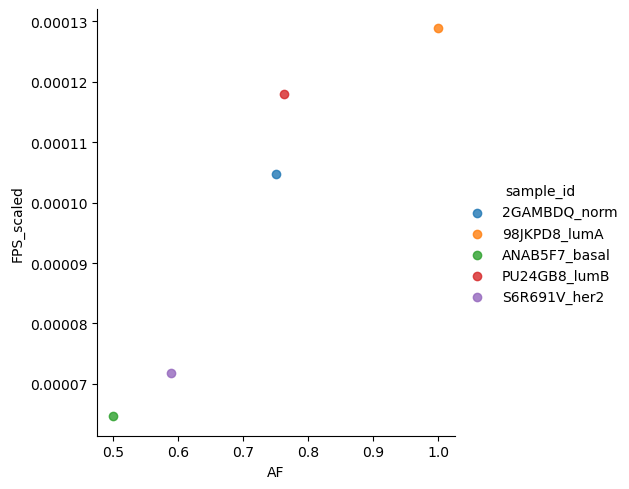

In [55]:
# plot a scatter plot
sns.lmplot(x='AF', y='FPS_scaled', data=covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == test_pos_regionid], hue='sample_id', fit_reg=True, height=5)

In [56]:
# now get the region_id string of the first row where corr_coeff == negative value
test_neg_regionid = corr_df_corrected_sig[corr_df_corrected_sig['corr_coeff'] < 0].iloc[0]['region_id']
test_neg_regionid

'chr1:39691463-39691485'

In [57]:
covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == test_neg_regionid]

region_id      sample_id        AF  FPS_scaled
3730  chr1:39691463-39691485   2GAMBDQ_norm  0.500000    0.000056
3731  chr1:39691463-39691485   98JKPD8_lumA  0.208333    0.000064
3732  chr1:39691463-39691485  ANAB5F7_basal  0.264706    0.000063
3733  chr1:39691463-39691485   PU24GB8_lumB  0.315789    0.000061
3734  chr1:39691463-39691485   S6R691V_her2  0.147059    0.000073

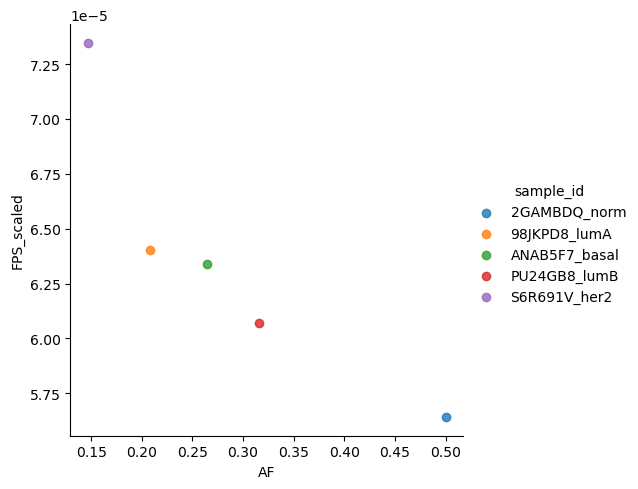

In [58]:
# plot a scatter plot
sns.lmplot(x='AF', y='FPS_scaled', data=covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == test_neg_regionid], hue='sample_id', fit_reg=True, height=5)

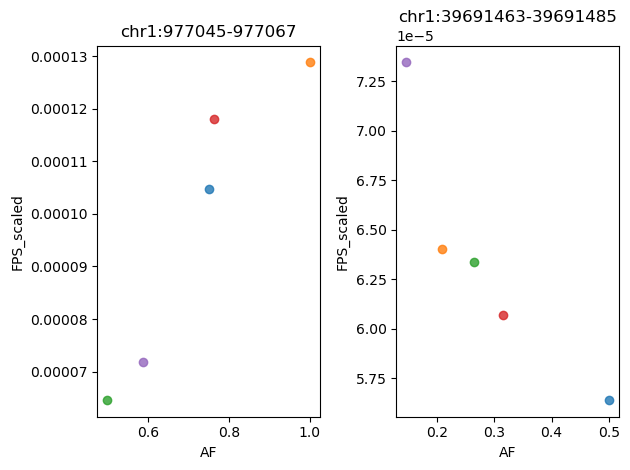

In [69]:
## lmplot is a FacetGrid object so it is not very straightforward to plot subplots. Had to use this custom function sourced from StackOverflow
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = plt.colormaps['tab10']
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    
    return regplots

# Two subplots
f, (ax1, ax2) = plt.subplots(1, 2)
# ax1.plot(df.x, df.y)
ax1.set_title(test_pos_regionid)
ax2.set_title(test_neg_regionid)
# remove y label from ax2
ax2.set_ylabel(' ')

hue_regplot(data=covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == test_pos_regionid], x='AF', y='FPS_scaled', hue='sample_id', ax=ax1)
hue_regplot(data=covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == test_neg_regionid], x='AF', y='FPS_scaled', hue='sample_id', ax=ax2)

plt.tight_layout()
plt.show()

#### ASIDE: Visualization of Correlation Coefficients at Filtered Covariant Sites

In [70]:
# corr_df_i = corr_df_corrected_sig.set_index('region_id')

# # Convert the DataFrame to a 2D format suitable for a heatmap
# df_2d = corr_df_i['corr_coeff'].to_numpy().reshape(-1, 1)

# # Create a heatmap
# plt.figure(figsize=(0.5,50))  # Adjust the figure size as needed
# sns.heatmap(df_2d, annot=True, cmap='coolwarm', xticklabels=False, yticklabels=corr_df_i.index)
# plt.show()

In [9]:
# import os
# import csv

# def extract_motif_names(path, extension, output_file):
#     data = []
#     for root, _, files in os.walk(path):
#         for file in files:
#             if file.endswith(extension):
#                 with open(os.path.join(root, file)) as f:
#                     first_line = f.readline()
#                     split_line = first_line.split()
#                     if len(split_line) > 1:
#                         tf_tuple = (split_line[0][1:], split_line[1])
#                         data.append(tf_tuple)
    
#     # sort the list of tuples by the first element, then second element
#     data.sort(key=lambda x: (x[1], x[0]))

#     # write the sorted list of tuples to a file
#     with open(output_file, 'w', newline='') as out_file:
#         writer = csv.writer(out_file, delimiter='\t')
#         writer.writerows(data)


# path = '/Users/sufyazi/Documents/local-storage/bioinf/repos/reference-TF-motifs/combined-filt-individual-motifs/individuals'
# extension = '.jaspar'
# output_file = '/Users/sufyazi/Documents/local-storage/bioinf/repos/reference-TF-motifs/combined-filt-individual-motifs/tf-motif-IDs-and-tf-names.tsv'

# extract_motif_names(path, extension, output_file)


## Annotating Covariant Sites

First extract TF IDs and TF classes from a manually curated TSV.

In [71]:
# first load the data table
annot_data = pd.read_csv('/Users/sufyazi/Documents/local-storage/bioinf/repos/reference-TF-motifs/combined-filt-individual-motifs/TF-motif-full-metadata-manual.tsv', sep='\t', header=0)

In [72]:
# Replace NaN values with 'N/A'
annot_data.fillna('N/A', inplace=True)

In [73]:
annot_data

motif_id  tf_name                                tf_class  \
0      AHR_HUMAN.H11MO.0.B      AHR   basic helix-loop-helix (bHLH) factors   
1     AIRE_HUMAN.H11MO.0.C     AIRE                     SAND domain factors   
2     ALX1_HUMAN.H11MO.0.B     ALX1                    homeo domain factors   
3     ANDR_HUMAN.H11MO.0.A     ANDR  nuclear receptors with C4 zinc fingers   
4     AP2A_HUMAN.H11MO.0.A     AP2A   basic helix-span-helix (bHSH) factors   
...                    ...      ...                                     ...   
1355              MA1602.1  ZSCAN29                C2H2 zinc finger factors   
1356           M08365_2.00  ZSCAN30                C2H2 zinc finger factors   
1357           M08270_2.00  ZSCAN31                C2H2 zinc finger factors   
1358           M08393_2.00  ZSCAN31                C2H2 zinc finger factors   
1359           M08390_2.00  ZSCAN5C                C2H2 zinc finger factors   

                                     tf_family  \
0                           PAS domain factors   
1                                         AIRE   
2                    paired-related HD factors   
3              steroid hormone receptors (NR3)   
4                  activating protein 2 (AP-2)   
...                                        ...   
1355  more than 3 adjacent zinc finger factors   
1356  more than 3 adjacent zinc finger factors   
1357  more than 3 adjacent zinc finger factors   
1358  more than 3 adjacent zinc finger factors   
1359  more than 3 adjacent zinc finger factors   

                         tf_subfamily  
0                    Ahr-like factors  
1                                AIRE  
2                                 ALX  
3            GR-like receptors (NR3C)  
4                                 N/A  
...                               ...  
1355              ZNF500-like factors  
1356                     unclassified  
1357               ZNF24-like factors  
1358               ZNF24-like factors  
1359  ZSCAN5-like zinc finger factors  

[1360 rows x 5 columns]

In [74]:
annot_data[annot_data['tf_name'] == 'STAT1STAT2']

motif_id     tf_name             tf_class     tf_family tf_subfamily
771  MA0517.1  STAT1STAT2  STAT domain factors  STAT factors          N/A

In [75]:
annot_data[annot_data['tf_family'] == 'T-brain-related factors']

motif_id tf_name       tf_class                tf_family  \
789  TBX21_HUMAN.H11MO.0.A   TBX21  T-box factors  T-brain-related factors   

    tf_subfamily  
789          N/A

The `motif_id` in this data table is not the same as the `motif_id` in the `merged_filt` table. This is because for some databases the TF name is not a part of the motif ID and thus need to be manually added. 

In [76]:
# go through the motif_id column and use the corresponding value in the tf_name column to do a match
# if there is a match, do nothing, else, add the tf_name to the motif_id by prefixing it and adding an underscore

# def add_prefix(row):
#     if row['tf_name'] not in row['motif_id']:
#         return row['tf_name'] + '_' + row['motif_id']
#     else:
#         return row['motif_id']

# scratch that; the motif_id in the other data table have redundant tf_name prefixes, so just use the motif_id as is

def add_prefix(row):
    return row['tf_name'] + '_' + row['motif_id']

annot_data['motif_id'] = annot_data.apply(add_prefix, axis=1)

In [77]:
annot_data

motif_id  tf_name  \
0       AHR_AHR_HUMAN.H11MO.0.B      AHR   
1     AIRE_AIRE_HUMAN.H11MO.0.C     AIRE   
2     ALX1_ALX1_HUMAN.H11MO.0.B     ALX1   
3     ANDR_ANDR_HUMAN.H11MO.0.A     ANDR   
4     AP2A_AP2A_HUMAN.H11MO.0.A     AP2A   
...                         ...      ...   
1355           ZSCAN29_MA1602.1  ZSCAN29   
1356        ZSCAN30_M08365_2.00  ZSCAN30   
1357        ZSCAN31_M08270_2.00  ZSCAN31   
1358        ZSCAN31_M08393_2.00  ZSCAN31   
1359        ZSCAN5C_M08390_2.00  ZSCAN5C   

                                    tf_class  \
0      basic helix-loop-helix (bHLH) factors   
1                        SAND domain factors   
2                       homeo domain factors   
3     nuclear receptors with C4 zinc fingers   
4      basic helix-span-helix (bHSH) factors   
...                                      ...   
1355                C2H2 zinc finger factors   
1356                C2H2 zinc finger factors   
1357                C2H2 zinc finger factors   
1358                C2H2 zinc finger factors   
1359                C2H2 zinc finger factors   

                                     tf_family  \
0                           PAS domain factors   
1                                         AIRE   
2                    paired-related HD factors   
3              steroid hormone receptors (NR3)   
4                  activating protein 2 (AP-2)   
...                                        ...   
1355  more than 3 adjacent zinc finger factors   
1356  more than 3 adjacent zinc finger factors   
1357  more than 3 adjacent zinc finger factors   
1358  more than 3 adjacent zinc finger factors   
1359  more than 3 adjacent zinc finger factors   

                         tf_subfamily  
0                    Ahr-like factors  
1                                AIRE  
2                                 ALX  
3            GR-like receptors (NR3C)  
4                                 N/A  
...                               ...  
1355              ZNF500-like factors  
1356                     unclassified  
1357               ZNF24-like factors  
1358               ZNF24-like factors  
1359  ZSCAN5-like zinc finger factors  

[1360 rows x 5 columns]

In [78]:
annot_data.head()

motif_id tf_name                                tf_class  \
0    AHR_AHR_HUMAN.H11MO.0.B     AHR   basic helix-loop-helix (bHLH) factors   
1  AIRE_AIRE_HUMAN.H11MO.0.C    AIRE                     SAND domain factors   
2  ALX1_ALX1_HUMAN.H11MO.0.B    ALX1                    homeo domain factors   
3  ANDR_ANDR_HUMAN.H11MO.0.A    ANDR  nuclear receptors with C4 zinc fingers   
4  AP2A_AP2A_HUMAN.H11MO.0.A    AP2A   basic helix-span-helix (bHSH) factors   

                         tf_family              tf_subfamily  
0               PAS domain factors          Ahr-like factors  
1                             AIRE                      AIRE  
2        paired-related HD factors                       ALX  
3  steroid hormone receptors (NR3)  GR-like receptors (NR3C)  
4      activating protein 2 (AP-2)                       N/A

In [68]:
# save the dataframe to a new file
# annot_data.to_csv('/Users/sufyazi/Documents/local-storage/bioinf/repos/reference-TF-motifs/combined-filt-individual-motifs/TF-motif-full-metadata-manual.processed.tsv', sep='\t', index=False)

In [80]:
# load modified annotation
annot_data_proc = pd.read_csv('/Users/sufyazi/Documents/local-storage/bioinf/repos/reference-TF-motifs/combined-filt-individual-motifs/TF-motif-full-metadata-manual.processed.tsv', sep='\t', header=0)
annot_data_proc.head()

motif_id tf_name                                tf_class  \
0    AHR_AHR_HUMAN.H11MO.0.B     AHR   basic helix-loop-helix (bHLH) factors   
1  AIRE_AIRE_HUMAN.H11MO.0.C    AIRE                     SAND domain factors   
2  ALX1_ALX1_HUMAN.H11MO.0.B    ALX1                    homeo domain factors   
3  ANDR_ANDR_HUMAN.H11MO.0.A    ANDR  nuclear receptors with C4 zinc fingers   
4  AP2A_AP2A_HUMAN.H11MO.0.A    AP2A   basic helix-span-helix (bHSH) factors   

                         tf_family              tf_subfamily  
0               PAS domain factors          Ahr-like factors  
1                             AIRE                      AIRE  
2        paired-related HD factors                       ALX  
3  steroid hormone receptors (NR3)  GR-like receptors (NR3C)  
4      activating protein 2 (AP-2)                       NaN

#### Visualizing Annotation Data

We can visualize the distribution of TF classes and TF IDs in the annotation data with a barplot.

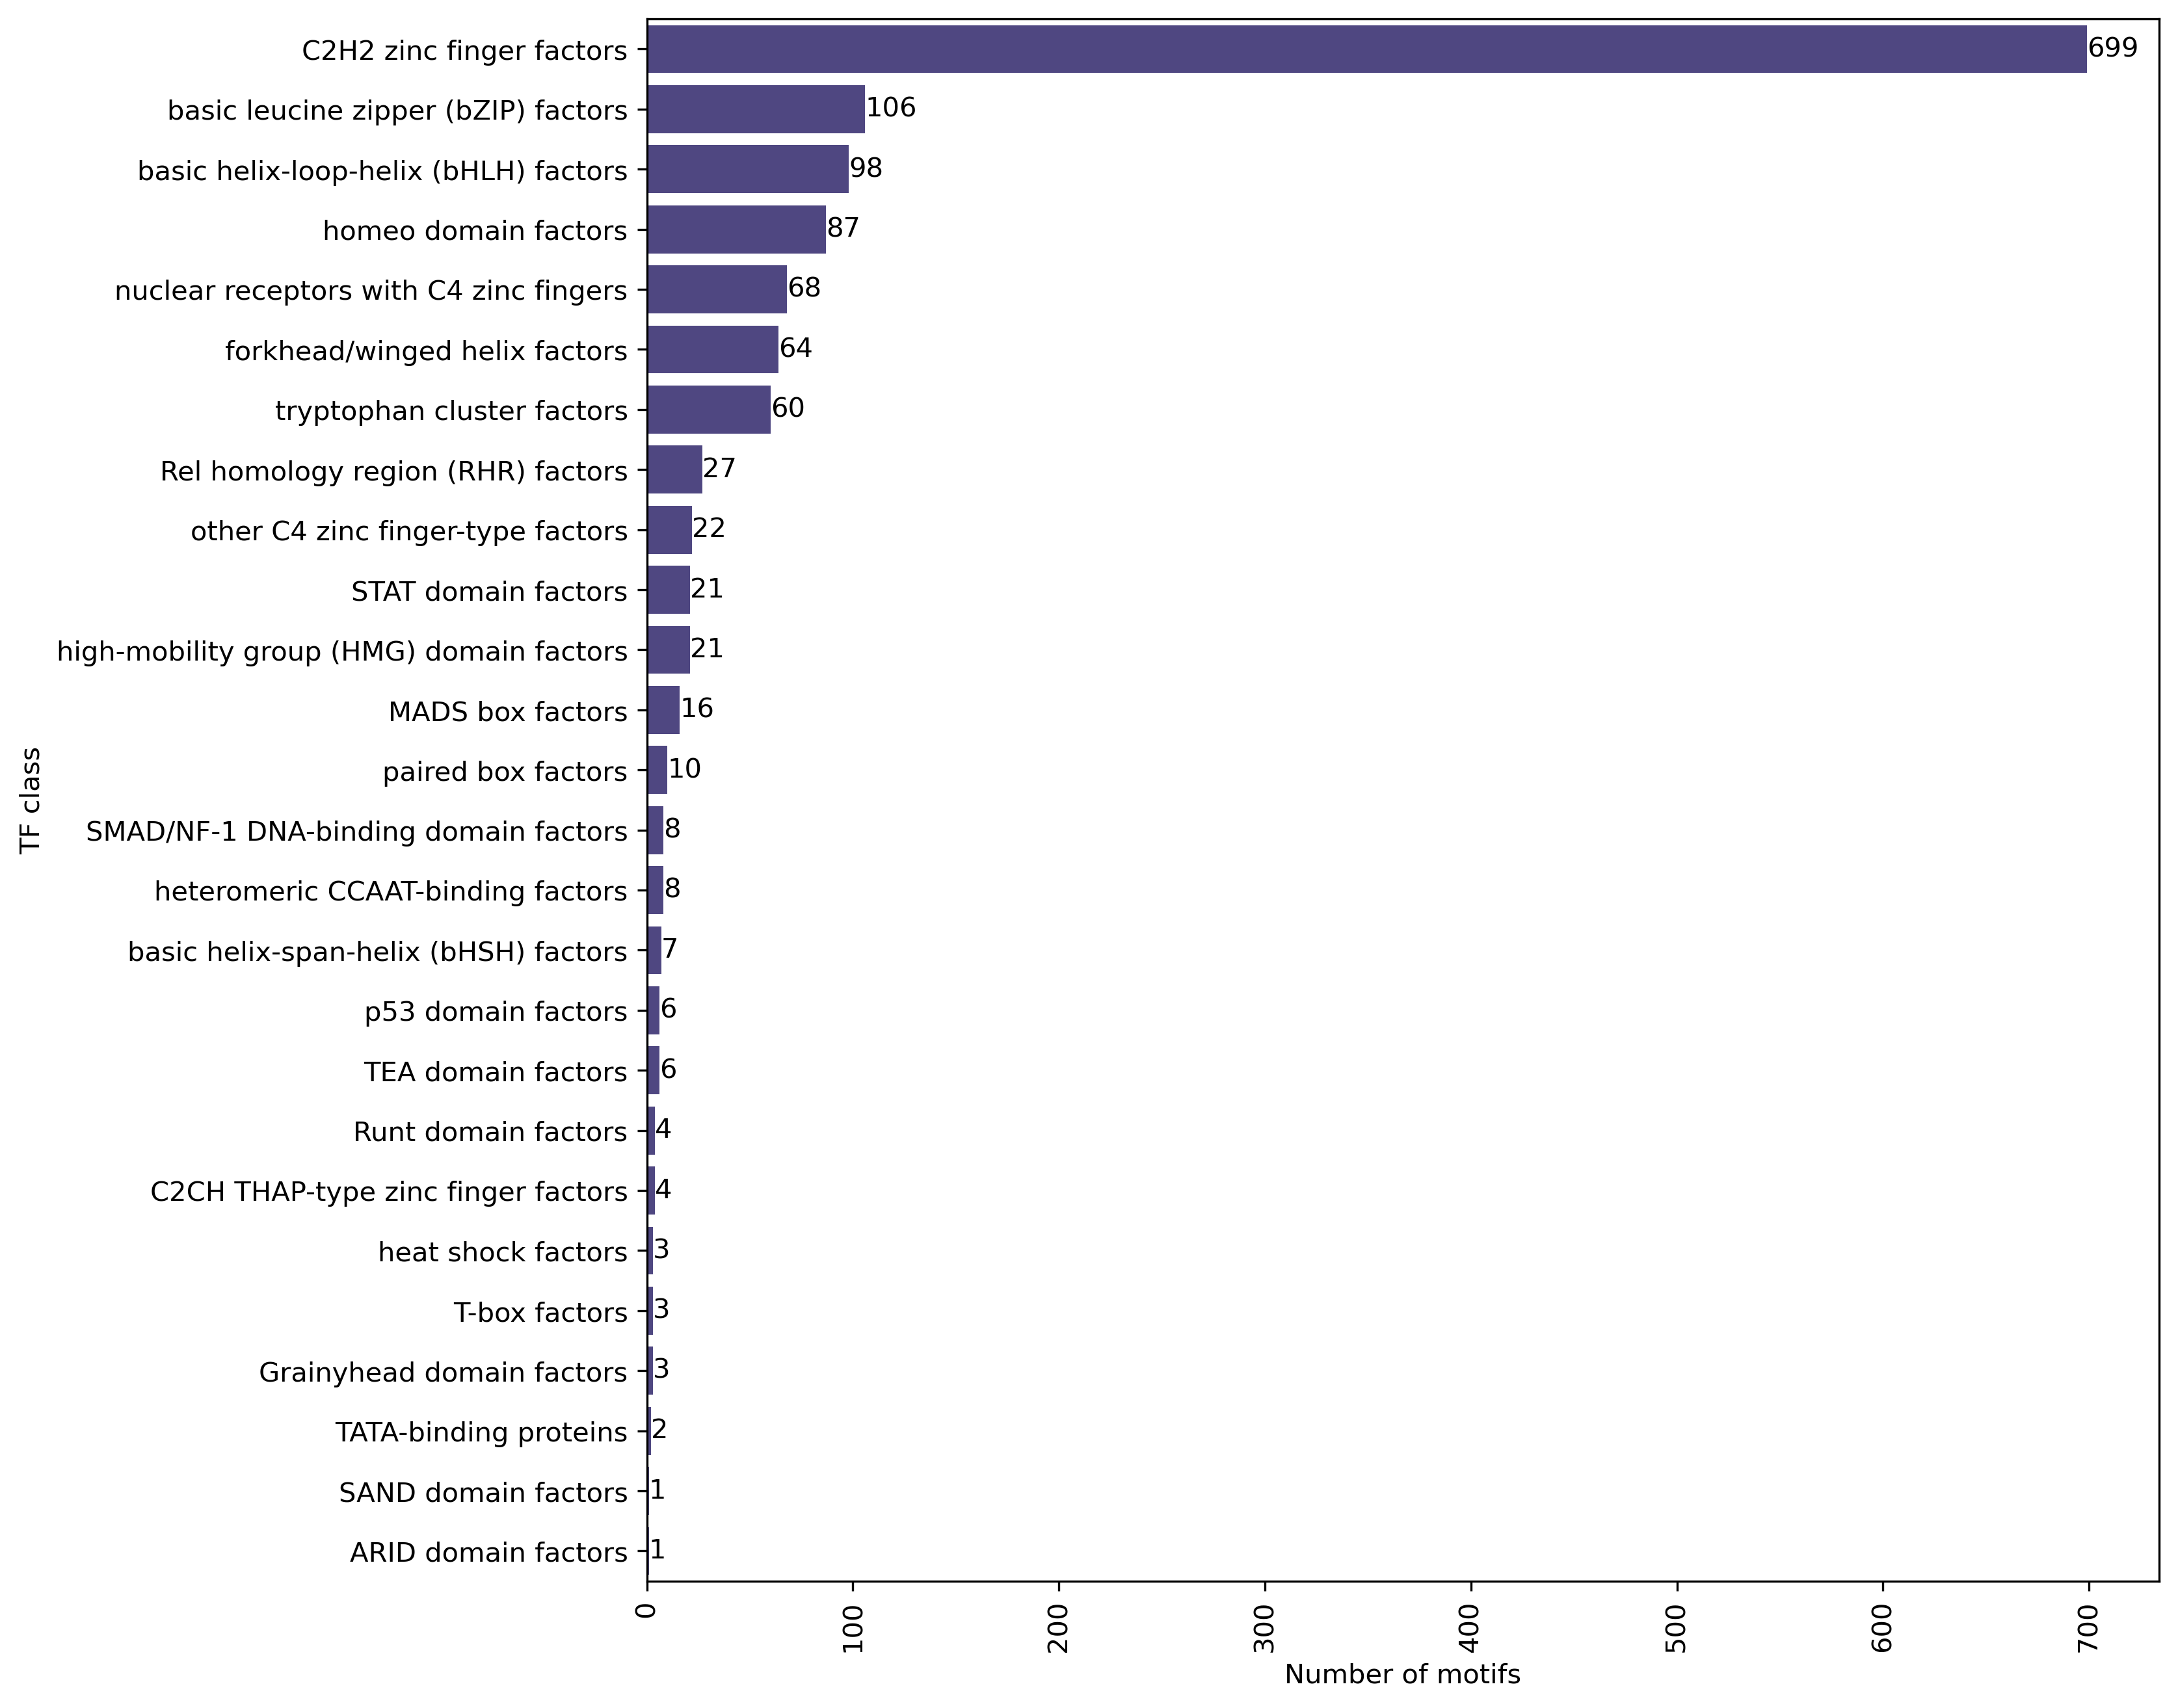

In [81]:
# Get the order of categories based on their counts
order = annot_data_proc['tf_class'].value_counts().index

# Create a larger figure
plt.figure(figsize=(10, len(order) * 0.4), dpi=300)

# Create a countplot with the order
ax = sns.countplot(y='tf_class', data=annot_data_proc, order=order,color='darkslateblue')

# Add counts to the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width,  
             p.get_y() + p.get_height() / 2,
             '{:1.0f}'.format(width),
             ha = 'left',
             va = 'center')

# Rotate x-axis labels for readability if they are long
plt.xticks(rotation=90)

#  y axis label
plt.ylabel('TF class')
# x axis label
plt.xlabel('Number of motifs')

# Save the plot as a high-resolution PDF
# plt.savefig("/Users/sufyazi/Documents/local-storage/bioinf/repos/fps-var-integration-local/output-data/plots/tf/TF-class-motif-counts-barplot.pdf", format='pdf', dpi=300)

# Show the plot
plt.show()

In [118]:
# Calculate the percentage for each tf_class
tf_class_counts = annot_data_proc['tf_class'].value_counts()
total_counts = len(annot_data_proc)
tf_class_percent = (tf_class_counts / total_counts) * 100

# create a new dataframe
tf_class_unique_df = pd.DataFrame({'tf_class': tf_class_percent.index,
                                   'tf_class_percent': tf_class_percent.values})

# Create a dictionary mapping each tf_class to a color from the custom palette
artemis = ["#ffa600", "#ff764a", "#ef5675", "#bc5090", "#7a5195", "#374c80", "#003f5c"]
abv_4percent_color = [class_name for class_name, percent in zip(tf_class_unique_df['tf_class'], tf_class_unique_df['tf_class_percent']) if percent > 4 ]
# create a color dictionary by zipping 
color_dict = dict(zip(abv_4percent_color, artemis))
# Add a new column by mapping values from the color dictionary 
tf_class_unique_df['color'] = tf_class_unique_df['tf_class'].map(color_dict)
# Replace all color values that is NaN with a lightgrey hex color
tf_class_unique_df['color'] = tf_class_unique_df['color'].replace(np.nan, '#D3D3D3')
# Add motif counts to the df by merging
tf_class_unique_df = tf_class_unique_df.merge(tf_class_counts.reset_index(), on='tf_class', how='left')


# Create pie chart 
fig = px.pie(tf_class_unique_df, names='tf_class', values='count', color='color', color_discrete_sequence=tf_class_unique_df['color'].unique(), title='TF Class Motif Counts')
fig.update_traces(textinfo='percent+label', textposition='inside', insidetextorientation='radial')

# Update the layout to make the pie chart larger
fig.update_layout(width=1000, height=1000)

fig.show()

In [121]:
# Save the figure as a high-resolution PNG image
# pio.write_image(fig, '/Users/sufyazi/Documents/local-storage/bioinf/repos/fps-var-integration-local/output-data/plots/tf/TF-class-motif-percents-piechart.pdf', scale=8)

In [120]:
# Get the counts of each category in the 'tf_class' column
class_counts = annot_data_proc['tf_class'].value_counts().to_frame()

# Rename the column for clarity
class_counts.columns = ['Motif Counts']

# rename the index to 'TF class'
class_counts.index.name = 'TF class'

# Display the DataFrame with conditional formatting
class_counts.style.background_gradient(cmap='Blues')

In [122]:
# Group by 'tf_class' and 'tf_family', and get the counts
class_family_counts = annot_data_proc.groupby(['tf_class', 'tf_family']).size().reset_index(name='Counts')

# Display the DataFrame with conditional formatting
class_family_counts.style.background_gradient(cmap='Blues')

In [123]:
# Group by 'tf_class' and 'tf_family', and get the counts
class_family_counts = annot_data_proc.groupby(['tf_class', 'tf_family']).size()

# Convert the series to a DataFrame and reset the index
class_family_counts = class_family_counts.to_frame(name='Counts').reset_index()

# Set a multi-index on 'tf_class' and 'family'
class_family_counts_multindex = class_family_counts.set_index(['tf_class', 'tf_family'])

# Display the DataFrame
# class_family_counts
class_family_counts_multindex

Counts
tf_class                           tf_family                                                 
ARID domain factors                ARID-related factors                                     1
C2CH THAP-type zinc finger factors THAP-related factors                                     4
C2H2 zinc finger factors           factors with multiple dispersed zinc fingers            87
                                   factors with multiple dispersed zinc fingers ZN...       1
                                   more than 3 adjacent zinc finger factors               557
...                                                                                       ...
paired box factors                 paired domain only                                       9
                                   paired plus homeo domain                                 1
tryptophan cluster factors         Ets-related factors                                     46
                                   Myb/SANT domain factors                                  5
                                   interferon-regulatory factors                            9

[67 rows x 1 columns]

In [102]:
# class_family_counts_multindex.to_excel('/Users/sufyazi/Documents/local-storage/bioinf/repos/fps-var-integration-local/output-data/plots/tf/TF-motif-class-family-counts.xlsx')

In [124]:
# draw hierarchical sunburst plot
orpurr = ["#03071e", "#370617", "#6a040f", "#9d0208", "#d00000", "#dc2f02", "#e85d04", "#f48c06", "#faa307", "#ffba08"]
fig = px.sunburst(class_family_counts, path=['tf_class', 'tf_family'], values='Counts', color='Counts', color_continuous_scale='Bluyl_r', title='TF class and family motif counts in the curated PWM set')

# Update the layout
fig.update_layout(width=1000, height=1000)

fig.show()


In [128]:
# Save the figure as a high-resolution PNG image
# pio.write_image(fig, '/Users/sufyazi/Documents/local-storage/bioinf/repos/fps-var-integration-local/output-data/plots/tf/TF-class-and-family-motif-cat-sunburstplot.pdf', scale=8)

## Merging Annotation Data with Covariant Sites

In [126]:
# load modified annotation
annot_data_proc = pd.read_csv('/Users/sufyazi/Documents/local-storage/bioinf/repos/reference-TF-motifs/combined-filt-individual-motifs/TF-motif-full-metadata-manual.processed.tsv', sep='\t', header=0)
annot_data_proc.head()

motif_id tf_name                                tf_class  \
0    AHR_AHR_HUMAN.H11MO.0.B     AHR   basic helix-loop-helix (bHLH) factors   
1  AIRE_AIRE_HUMAN.H11MO.0.C    AIRE                     SAND domain factors   
2  ALX1_ALX1_HUMAN.H11MO.0.B    ALX1                    homeo domain factors   
3  ANDR_ANDR_HUMAN.H11MO.0.A    ANDR  nuclear receptors with C4 zinc fingers   
4  AP2A_AP2A_HUMAN.H11MO.0.A    AP2A   basic helix-span-helix (bHSH) factors   

                         tf_family              tf_subfamily  
0               PAS domain factors          Ahr-like factors  
1                             AIRE                      AIRE  
2        paired-related HD factors                       ALX  
3  steroid hormone receptors (NR3)  GR-like receptors (NR3C)  
4      activating protein 2 (AP-2)                       NaN

In [127]:
# load the covariant sites data
sig_covariant_sites = pd.read_csv('/Users/sufyazi/Documents/local-storage/bioinf/repos/fps-var-integration-local/output-data/covariant-site-counts/AF_FPS-covariant_sites_significant.combined.tsv', sep='\t', header=0)

sig_covariant_sites

orig_index                   motif_id                 region_id  \
0             71  AIRE_AIRE_HUMAN.H11MO.0.C     chr16:3282261-3282279   
1             77  AIRE_AIRE_HUMAN.H11MO.0.C   chr17:49374914-49374932   
2             24  AIRE_AIRE_HUMAN.H11MO.0.C    chr6:76866202-76866220   
3             14  ALX1_ALX1_HUMAN.H11MO.0.B  chr2:225782219-225782231   
4            244  ANDR_ANDR_HUMAN.H11MO.0.A   chr14:99571643-99571661   
...          ...                        ...                       ...   
4896         122        ZSCAN31_M08393_2.00   chr18:13246839-13246854   
4897          36        ZSCAN31_M08393_2.00    chr5:53402883-53402898   
4898          37        ZSCAN5C_M08390_2.00  chr7:133512687-133512702   
4899          36        ZSCAN5C_M08390_2.00    chr7:98352788-98352803   
4900          43        ZSCAN5C_M08390_2.00  chr8:142727247-142727262   

      corr_coeff       pvalues   adj_pvalues  
0           -1.0  1.404265e-24  4.446841e-23  
1            1.0  1.404265e-24  4.446841e-23  
2            1.0  1.404265e-24  4.446841e-23  
3            1.0  1.404265e-24  6.740474e-23  
4           -1.0  1.404265e-24  1.507245e-22  
...          ...           ...           ...  
4896        -1.0  1.404265e-24  9.689431e-23  
4897        -1.0  1.404265e-24  9.689431e-23  
4898         1.0  1.404265e-24  3.744708e-23  
4899        -1.0  1.404265e-24  3.744708e-23  
4900         1.0  1.404265e-24  3.744708e-23  

[4901 rows x 6 columns]

### Counting and visualizing TFs with significant co-variant sites

First we can take a look at which TFs are top in terms of significant co-variant sites.

In [143]:
# group the merged dataframe by 'motif_id' and count the number of unique 'region_id' values
motif_counts = sig_covariant_sites.groupby('motif_id')['region_id'].nunique().reset_index()

# rename the 'region_id' column to 'site_counts'
motif_counts = motif_counts.rename(columns={'region_id': 'site_counts'})

# sort rows by 'region_id' in descending order
motif_counts = motif_counts.sort_values(by='site_counts', ascending=False)

motif_counts

motif_id  site_counts
801  ZN770_ZN770_HUMAN.H11MO.0.C           27
773  ZN281_ZN281_HUMAN.H11MO.0.A           27
869           ZNF263_M08082_2.00           26
342    KLF6_KLF6_HUMAN.H11MO.0.A           26
695      WT1_WT1_HUMAN.H11MO.0.C           24
..                           ...          ...
351                LHX2_MA0700.2            1
352    LHX3_LHX3_HUMAN.H11MO.0.C            1
355             MAFF_M07839_2.00            1
357                MAFF_MA0495.3            1
278    HXB7_HXB7_HUMAN.H11MO.0.C            1

[1153 rows x 2 columns]

In [145]:
# merge the two dataframes on 'motif_id'
merged_annot_covar = motif_counts.merge(annot_data_proc, on='motif_id')

merged_annot_covar.head(10)

motif_id  site_counts tf_name                  tf_class  \
0  ZN770_ZN770_HUMAN.H11MO.0.C           27   ZN770  C2H2 zinc finger factors   
1  ZN281_ZN281_HUMAN.H11MO.0.A           27   ZN281  C2H2 zinc finger factors   
2           ZNF263_M08082_2.00           26  ZNF263  C2H2 zinc finger factors   
3    KLF6_KLF6_HUMAN.H11MO.0.A           26    KLF6  C2H2 zinc finger factors   
4      WT1_WT1_HUMAN.H11MO.0.C           24     WT1  C2H2 zinc finger factors   
5  ZN467_ZN467_HUMAN.H11MO.0.C           23   ZN467  C2H2 zinc finger factors   
6      SP4_SP4_HUMAN.H11MO.0.A           22     SP4  C2H2 zinc finger factors   
7      SP3_SP3_HUMAN.H11MO.0.B           22     SP3  C2H2 zinc finger factors   
8      SP2_SP2_HUMAN.H11MO.0.A           22     SP2  C2H2 zinc finger factors   
9  PATZ1_PATZ1_HUMAN.H11MO.0.C           22   PATZ1  C2H2 zinc finger factors   

                                      tf_family          tf_subfamily  
0  factors with multiple dispersed zinc fingers          unclassified  
1      more than 3 adjacent zinc finger factors   ZNF148-like factors  
2      more than 3 adjacent zinc finger factors          unclassified  
3     three-zinc finger Krüppel-related factors  Krüppel-like factors  
4      more than 3 adjacent zinc finger factors          unclassified  
5  factors with multiple dispersed zinc fingers          unclassified  
6     three-zinc finger Krüppel-related factors      Sp1-like factors  
7     three-zinc finger Krüppel-related factors      Sp1-like factors  
8     three-zinc finger Krüppel-related factors      Sp1-like factors  
9  factors with multiple dispersed zinc fingers      MAZ-like factors

In [146]:
merged_annot_covar.iloc[10:50]

motif_id  site_counts tf_name  \
10           ZNF383_M07689_2.00           21  ZNF383   
11      MAZ_MAZ_HUMAN.H11MO.0.A           21     MAZ   
12  ZN263_ZN263_HUMAN.H11MO.0.A           19   ZN263   
13           ZNF263_M07843_2.00           19  ZNF263   
14               PRDM9_MA1723.1           19   PRDM9   
15           ZNF529_M07678_2.00           19  ZNF529   
16  ZBT17_ZBT17_HUMAN.H11MO.0.A           19   ZBT17   
17           ZNF341_M08310_2.00           18  ZNF341   
18  ZSC22_ZSC22_HUMAN.H11MO.0.C           18   ZSC22   
19           ZNF432_M07773_2.00           18  ZNF432   
20           ZNF880_M07764_2.00           18  ZNF880   
21            ZNF93_M07671_2.00           18   ZNF93   
22              ZNF148_MA1653.1           17  ZNF148   
23              SP1_M08363_2.00           17     SP1   
24           ZNF281_M08321_2.00           17  ZNF281   
25              ZNF281_MA1630.2           17  ZNF281   
26              ZNF460_MA1596.1           17  ZNF460   
27  VEZF1_VEZF1_HUMAN.H11MO.0.C           17   VEZF1   
28           ZNF180_M07614_2.00           16  ZNF180   
29           ZNF467_M08260_2.00           16  ZNF467   
30           ZNF304_M07587_2.00           16  ZNF304   
31    EGR2_EGR2_HUMAN.H11MO.0.A           16    EGR2   
32                CTCF_MA1929.1           16    CTCF   
33            PRDM9_M07610_2.00           15   PRDM9   
34    EGR1_EGR1_HUMAN.H11MO.0.A           15    EGR1   
35    KLF3_KLF3_HUMAN.H11MO.0.B           15    KLF3   
36  KLF15_KLF15_HUMAN.H11MO.0.A           15   KLF15   
37           ZNF519_M07642_2.00           15  ZNF519   
38            KLF10_M08317_2.00           15   KLF10   
39              SP2_M08092_2.00           15     SP2   
40                 MAZ_MA1522.1           14     MAZ   
41           ZNF121_M08384_2.00           14  ZNF121   
42           ZNF283_M07619_2.00           14  ZNF283   
43  ZN341_ZN341_HUMAN.H11MO.0.C           14   ZN341   
44  THAP1_THAP1_HUMAN.H11MO.0.C           14   THAP1   
45            ZFP28_M08378_2.00           14   ZFP28   
46               PATZ1_MA1961.1           14   PATZ1   
47           ZNF548_M07691_2.00           14  ZNF548   
48           ZNF235_M07605_2.00           14  ZNF235   
49           ZNF484_M07581_2.00           13  ZNF484   

                              tf_class  \
10            C2H2 zinc finger factors   
11            C2H2 zinc finger factors   
12            C2H2 zinc finger factors   
13            C2H2 zinc finger factors   
14            C2H2 zinc finger factors   
15            C2H2 zinc finger factors   
16            C2H2 zinc finger factors   
17            C2H2 zinc finger factors   
18            C2H2 zinc finger factors   
19            C2H2 zinc finger factors   
20            C2H2 zinc finger factors   
21            C2H2 zinc finger factors   
22            C2H2 zinc finger factors   
23            C2H2 zinc finger factors   
24            C2H2 zinc finger factors   
25            C2H2 zinc finger factors   
26            C2H2 zinc finger factors   
27            C2H2 zinc finger factors   
28            C2H2 zinc finger factors   
29            C2H2 zinc finger factors   
30            C2H2 zinc finger factors   
31            C2H2 zinc finger factors   
32            C2H2 zinc finger factors   
33            C2H2 zinc finger factors   
34            C2H2 zinc finger factors   
35            C2H2 zinc finger factors   
36            C2H2 zinc finger factors   
37            C2H2 zinc finger factors   
38            C2H2 zinc finger factors   
39            C2H2 zinc finger factors   
40            C2H2 zinc finger factors   
41            C2H2 zinc finger factors   
42            C2H2 zinc finger factors   
43            C2H2 zinc finger factors   
44  C2CH THAP-type zinc finger factors   
45            C2H2 zinc finger factors   
46            C2H2 zinc finger factors   
47            C2H2 zinc finger factors   
48            C2H2 zinc finger factors   
49            C2H2 zinc finger factors   

   

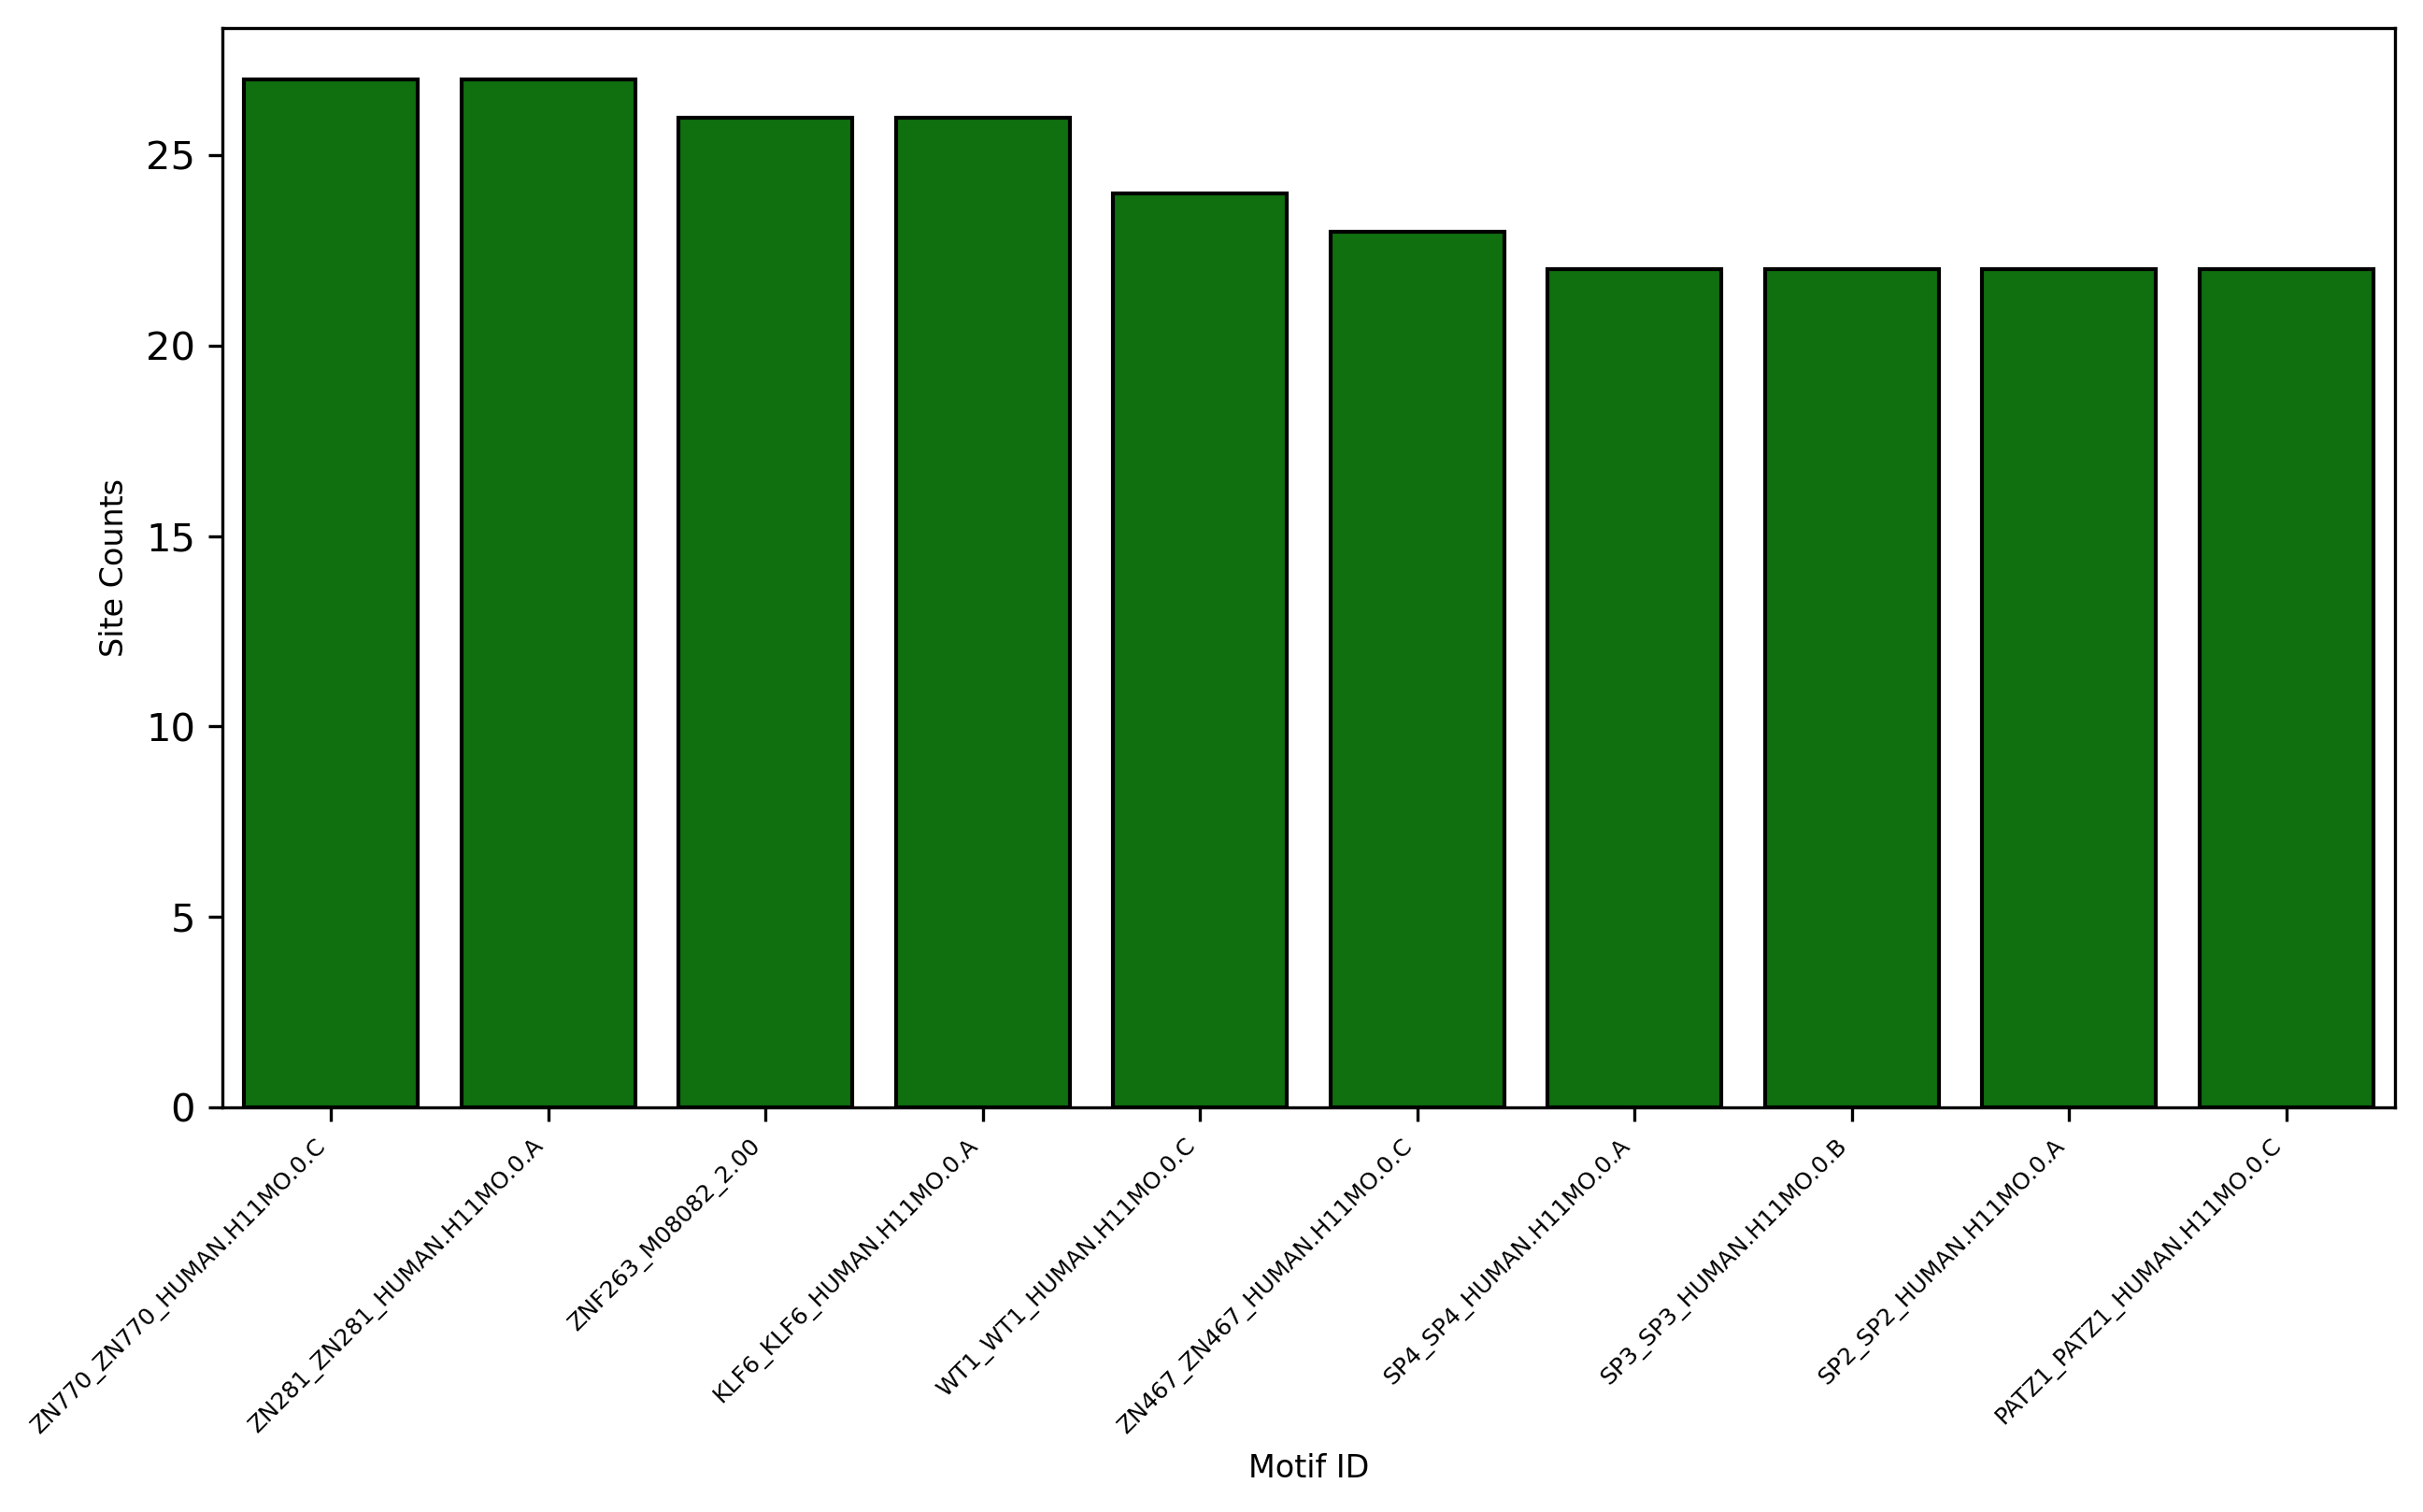

In [155]:
# plot countplot of motif counts
plt.figure(figsize=(10, 5), dpi=300)
p = sns.barplot(x='motif_id', y='site_counts', data=merged_annot_covar.iloc[:10], color='green', edgecolor='black')
p.tick_params(axis='y', labelsize=10)
p.tick_params(axis='x', labelsize=6)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Motif ID', fontsize=8)
plt.ylabel('Site Counts', fontsize=8)
plt.show()

### Load the allelic information from the original data table


In [128]:
allelic_df = dt_afps.filter(regex='_allele$|_pos$|_id$').copy()
allelic_df.head(5)

2GAMBDQ_norm_varsite_pos 2GAMBDQ_norm_ref_allele 2GAMBDQ_norm_alt_allele  \
0                       NaN                     NaN                     NaN   
1                  136940.0                       G                       T   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     NaN   
4                       NaN                     NaN                     NaN   

   98JKPD8_lumA_varsite_pos 98JKPD8_lumA_ref_allele 98JKPD8_lumA_alt_allele  \
0                   29443.0                       A                       G   
1                       NaN                     NaN                     NaN   
2                  181526.0                       C                       T   
3                       NaN                     NaN                     NaN   
4                  182785.0                       A                       G   

   ANAB5F7_basal_varsite_pos ANAB5F7_basal_ref_allele  \
0                    29443.0                        A   
1                   136940.0                        G   
2                   181526.0                        C   
3                        NaN                      NaN   
4                        NaN                      NaN   

  ANAB5F7_basal_alt_allele  PU24GB8_lumB_varsite_pos PU24GB8_lumB_ref_allele  \
0                        G                   29443.0                       A   
1                        T                  136939.0                       G   
2                        T                  181526.0                       C   
3                      NaN                  181573.0                       G   
4                      NaN                  182785.0                       A   

  PU24GB8_lumB_alt_allele  S6R691V_her2_varsite_pos S6R691V_her2_ref_allele  \
0                       G                   29443.0                       A   
1                       T                       NaN                     NaN   
2                       T                  181526.0                       C   
3                       A                  181583.0      CGGGGGGGGGGGGGGGGG   
4                       G                       NaN                     NaN   

  S6R691V_her2_alt_allele           region_id  
0                       G    chr1:29434-29456  
1                     NaN  chr1:136931-136953  
2                       T  chr1:181521-181543  
3          CGGGGGGGGGGGGG  chr1:181572-181594  
4                     NaN  chr1:182780-182802

In [129]:
# check if region_id is not unique
region_id_counts = allelic_df['region_id'].value_counts()
if region_id_counts.max() > 1:
    print(f"region_id is not unique: {region_id_counts.idxmax()}")
else:
    print("region_id column is unique")


region_id column is unique


Hence we melt the data table into a long form.

In [136]:
allelic_df_long = allelic_df.melt(id_vars=["region_id"], var_name="variable", value_name="value")
allelic_df_long

region_id                  variable     value
0              chr1:29434-29456  2GAMBDQ_norm_varsite_pos       NaN
1            chr1:136931-136953  2GAMBDQ_norm_varsite_pos  136940.0
2            chr1:181521-181543  2GAMBDQ_norm_varsite_pos       NaN
3            chr1:181572-181594  2GAMBDQ_norm_varsite_pos       NaN
4            chr1:182780-182802  2GAMBDQ_norm_varsite_pos       NaN
...                         ...                       ...       ...
1719310  chrY:26671025-26671047   S6R691V_her2_alt_allele       NaN
1719311  chrY:26671055-26671077   S6R691V_her2_alt_allele       NaN
1719312  chrY:26671150-26671172   S6R691V_her2_alt_allele         T
1719313  chrY:26671670-26671692   S6R691V_her2_alt_allele       NaN
1719314  chrY:26671746-26671768   S6R691V_her2_alt_allele       NaN

[1719315 rows x 3 columns]

In [137]:
# Create a new column 'type' based on the 'variable' column
allelic_df_long['type'] = np.where(allelic_df_long['variable'].str.contains('_pos'), 'pos', 'allele')
allelic_df_long

region_id                  variable     value    type
0              chr1:29434-29456  2GAMBDQ_norm_varsite_pos       NaN     pos
1            chr1:136931-136953  2GAMBDQ_norm_varsite_pos  136940.0     pos
2            chr1:181521-181543  2GAMBDQ_norm_varsite_pos       NaN     pos
3            chr1:181572-181594  2GAMBDQ_norm_varsite_pos       NaN     pos
4            chr1:182780-182802  2GAMBDQ_norm_varsite_pos       NaN     pos
...                         ...                       ...       ...     ...
1719310  chrY:26671025-26671047   S6R691V_her2_alt_allele       NaN  allele
1719311  chrY:26671055-26671077   S6R691V_her2_alt_allele       NaN  allele
1719312  chrY:26671150-26671172   S6R691V_her2_alt_allele         T  allele
1719313  chrY:26671670-26671692   S6R691V_her2_alt_allele       NaN  allele
1719314  chrY:26671746-26671768   S6R691V_her2_alt_allele       NaN  allele

[1719315 rows x 4 columns]

Now get the `region_id` as a list from the significant covariant sites.

In [138]:
# get region_id from sig_covariant_sites
region_ids_sig = sig_covariant_sites['region_id'].tolist()
len(region_ids_sig)

4901

In [139]:
# filter the allelic_df_long to only include region_ids in region_ids
allelic_df_long_filt = allelic_df_long[allelic_df_long['region_id'].isin(region_ids_sig)]
allelic_df_long_filt

region_id                  variable        value  \
78             chr1:977045-977067  2GAMBDQ_norm_varsite_pos     977055.0   
3671       chr1:39691463-39691485  2GAMBDQ_norm_varsite_pos   39691471.0   
7933     chr1:183734867-183734889  2GAMBDQ_norm_varsite_pos  183734880.0   
8554     chr1:203792569-203792591  2GAMBDQ_norm_varsite_pos  203792588.0   
14889    chr2:109146835-109146857  2GAMBDQ_norm_varsite_pos  109146840.0   
...                           ...                       ...          ...   
1708844   chr20:34026065-34026087   S6R691V_her2_alt_allele            G   
1713705   chr22:21630085-21630107   S6R691V_her2_alt_allele            A   
1715849   chr22:46054401-46054423   S6R691V_her2_alt_allele            T   
1715929   chr22:46487531-46487553   S6R691V_her2_alt_allele            G   
1716681      chrX:1661584-1661606   S6R691V_her2_alt_allele            A   

           type  
78          pos  
3671        pos  
7933        pos  
8554        pos  
14889       pos  
...         ...  
1708844  allele  
1713705  allele  
1715849  allele  
1715929  allele  
1716681  allele  

[375 rows x 4 columns]

In [141]:
# split the dataframe into two based on the 'type' column
allelic_pos = allelic_df_long_filt[allelic_df_long_filt['type'] == 'pos']
allelic_pos

region_id                  variable        value type
78             chr1:977045-977067  2GAMBDQ_norm_varsite_pos     977055.0  pos
3671       chr1:39691463-39691485  2GAMBDQ_norm_varsite_pos   39691471.0  pos
7933     chr1:183734867-183734889  2GAMBDQ_norm_varsite_pos  183734880.0  pos
8554     chr1:203792569-203792591  2GAMBDQ_norm_varsite_pos  203792588.0  pos
14889    chr2:109146835-109146857  2GAMBDQ_norm_varsite_pos  109146840.0  pos
...                           ...                       ...          ...  ...
1479602   chr20:34026065-34026087  S6R691V_her2_varsite_pos   34026067.0  pos
1484463   chr22:21630085-21630107  S6R691V_her2_varsite_pos   21630090.0  pos
1486607   chr22:46054401-46054423  S6R691V_her2_varsite_pos   46054417.0  pos
1486687   chr22:46487531-46487553  S6R691V_her2_varsite_pos   46487548.0  pos
1487439      chrX:1661584-1661606  S6R691V_her2_varsite_pos    1661605.0  pos

[125 rows x 4 columns]

In [142]:
allelic_allele = allelic_df_long_filt[allelic_df_long_filt['type'] == 'allele']
allelic_allele

region_id                 variable value    type
114699         chr1:977045-977067  2GAMBDQ_norm_ref_allele     G  allele
118292     chr1:39691463-39691485  2GAMBDQ_norm_ref_allele     C  allele
122554   chr1:183734867-183734889  2GAMBDQ_norm_ref_allele     T  allele
123175   chr1:203792569-203792591  2GAMBDQ_norm_ref_allele     C  allele
129510   chr2:109146835-109146857  2GAMBDQ_norm_ref_allele     C  allele
...                           ...                      ...   ...     ...
1708844   chr20:34026065-34026087  S6R691V_her2_alt_allele     G  allele
1713705   chr22:21630085-21630107  S6R691V_her2_alt_allele     A  allele
1715849   chr22:46054401-46054423  S6R691V_her2_alt_allele     T  allele
1715929   chr22:46487531-46487553  S6R691V_her2_alt_allele     G  allele
1716681      chrX:1661584-1661606  S6R691V_her2_alt_allele     A  allele

[250 rows x 4 columns]